In [7]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt


# Analyze the WFP mVAM FCS data (district level, 2020-2021.5) from Martini et al. (2024)
Our goal here is to investigate the infrannual FCS dynamics via statistics 
1) subset Sub-Saharan Africa in the data
2) analyze each timeseries: generate a statistical summary including mean, coeff. of var., and power spectrum peak

In [8]:
#
#part 1
#
sub_saharan_africa_list = [
    'Angola',
    'Benin',
    'Botswana',
    'Burkina Faso',
    'Burundi',
    'Cabo Verde', # Note: Your list has 'Cape Verde'
    'Cape Verde', # Include the name as it appears in your list
    'Cameroon',
    'Central African Republic',
    'Chad',
    'Comoros',
    'Congo', # Refers to the Republic of the Congo
    'Democratic Republic of the Congo',
    "Côte d'Ivoire",
    'Djibouti',
    'Equatorial Guinea',
    'Eritrea',
    'Eswatini',
    'Ethiopia',
    'Gabon',
    'Gambia',
    'Ghana',
    'Guinea',
    'Guinea-Bissau',
    'Kenya',
    'Lesotho',
    'Liberia',
    'Madagascar',
    'Malawi',
    'Mali',
    'Mauritania',
    'Mauritius',
    'Mayotte', # French overseas department, geographically included
    'Mozambique',
    'Namibia',
    'Niger',
    'Nigeria',
    'Réunion', # French overseas department, geographically included
    'Rwanda',
    'Saint Helena', # British Overseas Territory, geographically included
    'Sao Tome and Principe',
    'Senegal',
    'Seychelles',
    'Sierra Leone',
    'Somalia',
    'South Africa',
    'South Sudan',
    'Sudan', # Often included, though sometimes grouped with North Africa
    'Swaziland', # Older name for Eswatini, present in your list
    'Togo',
    'Uganda',
    'United Republic of Tanzania', # Matches the name in your list
    'Zambia',
    'Zimbabwe'
]
import numpy as np
# 3. Perform the 'isin' check
is_in_ssa = np.isin('Zambia', sub_saharan_africa_list)


In [9]:
import pandas as pd
fs_data_harmonized = pd.read_csv(r'C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\HFID_hv1.csv')

### Visualize monthly temporal availability of HFID data 

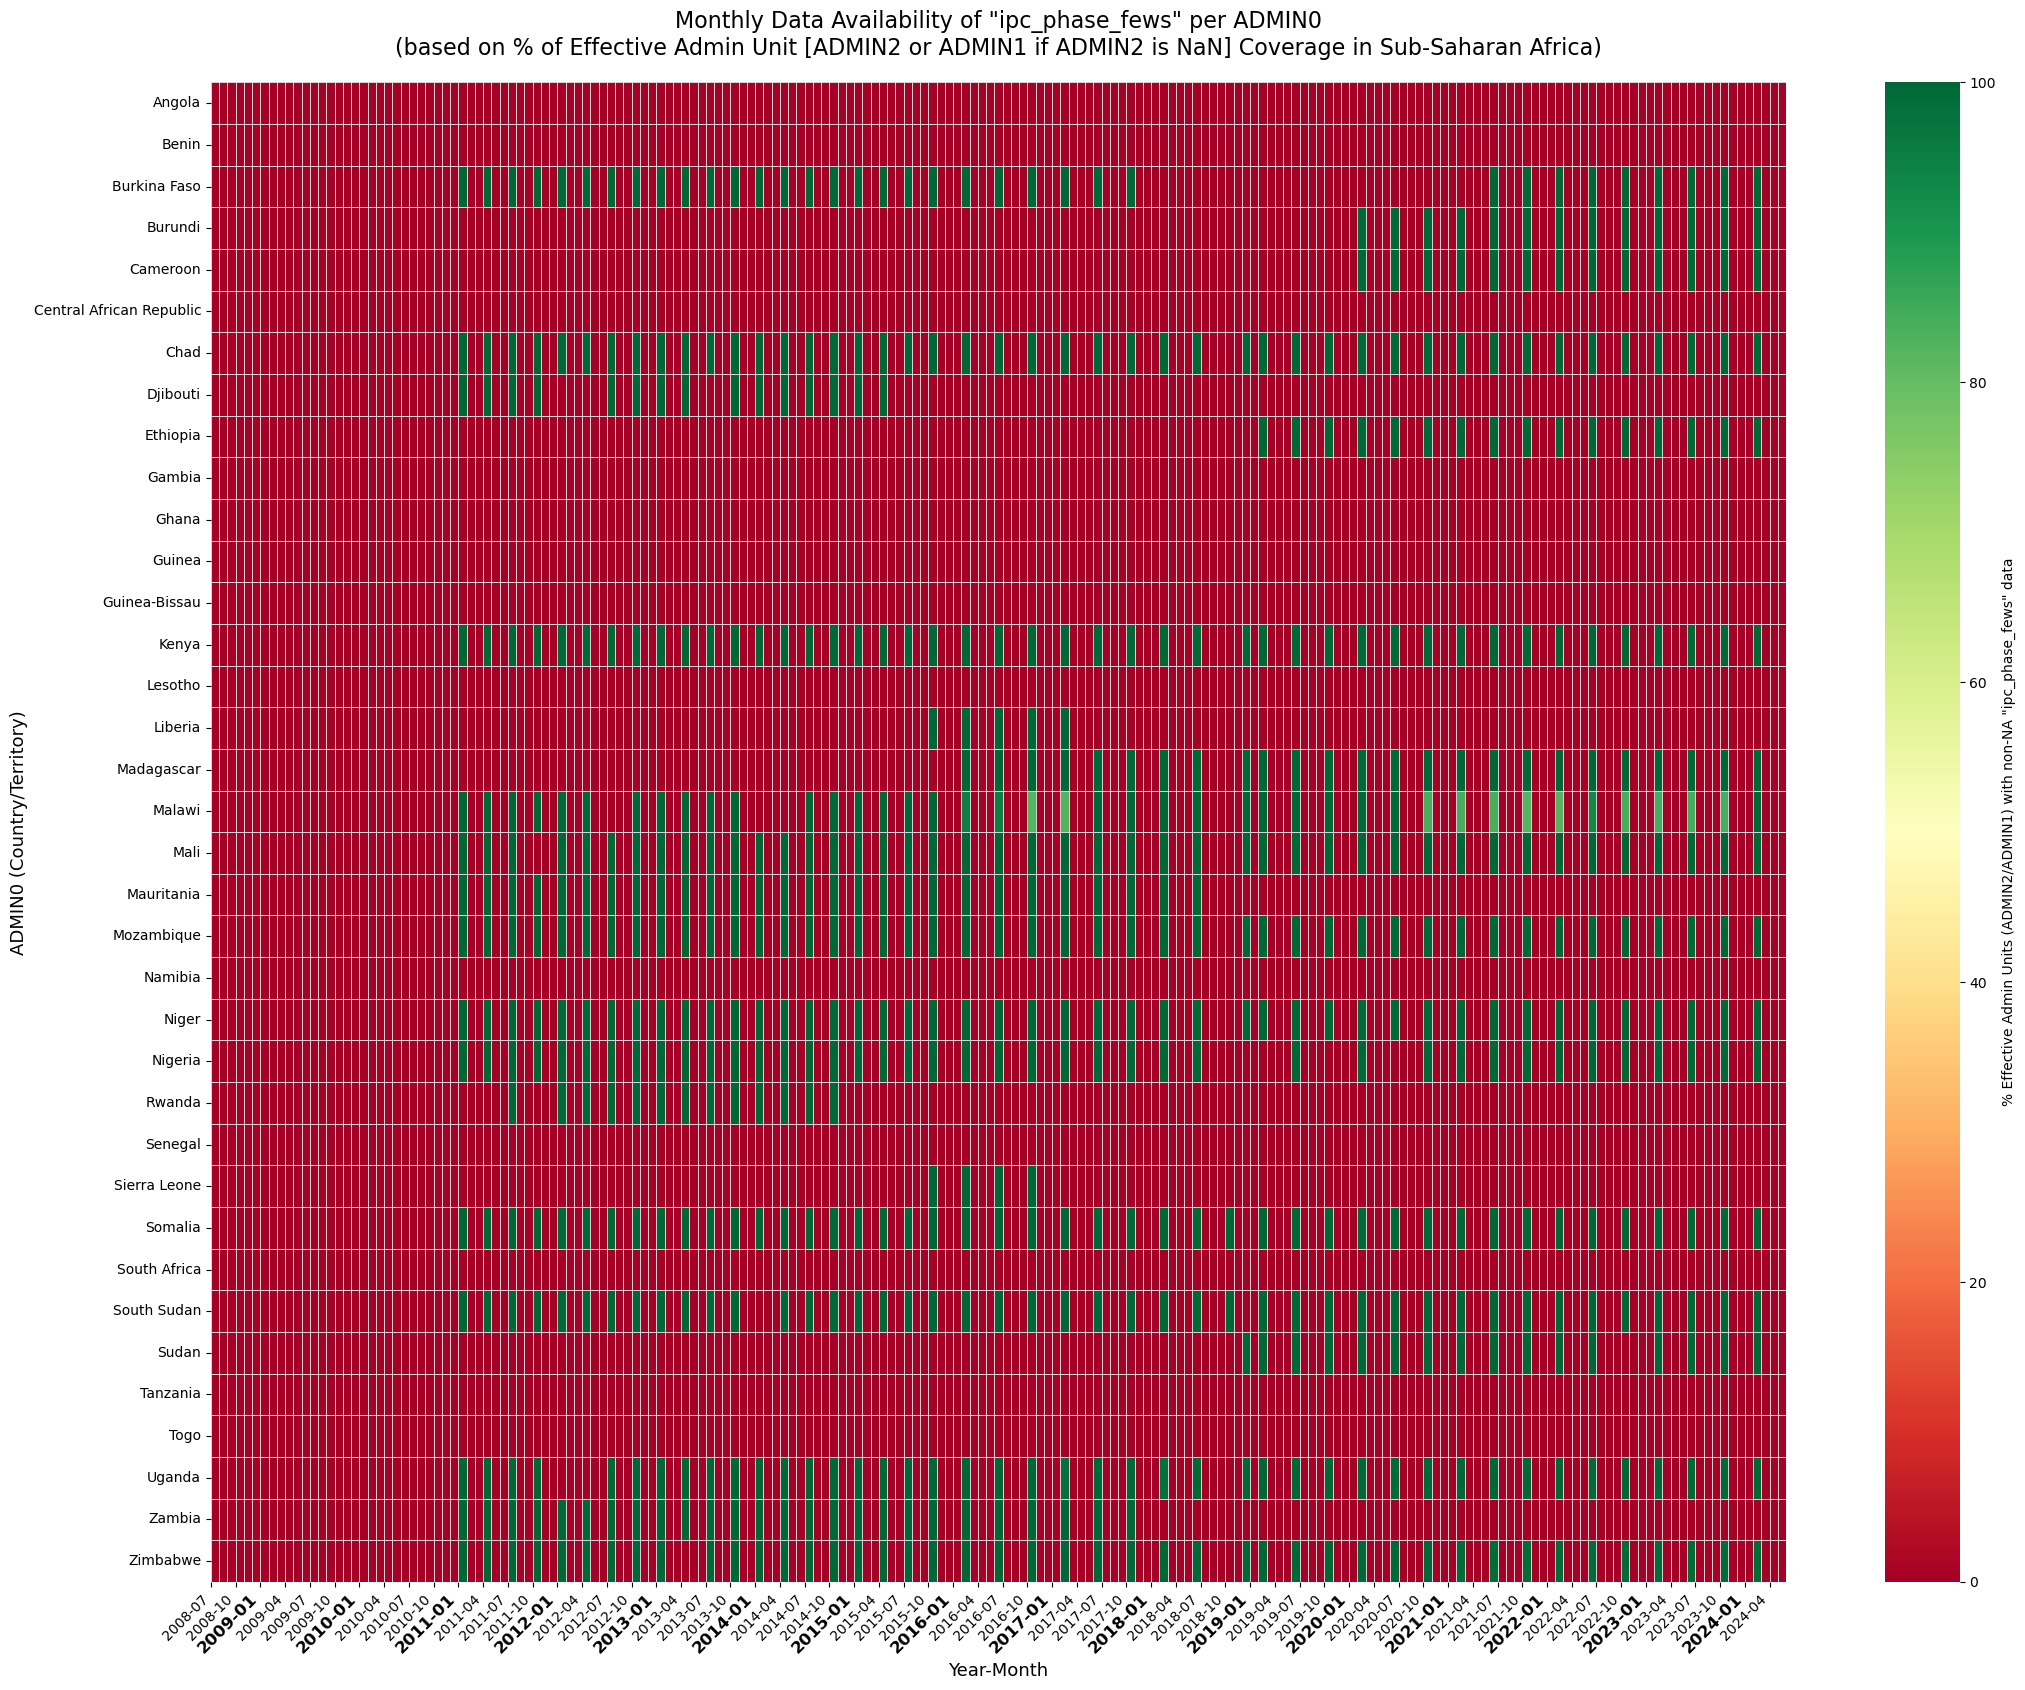

<Figure size 640x480 with 0 Axes>

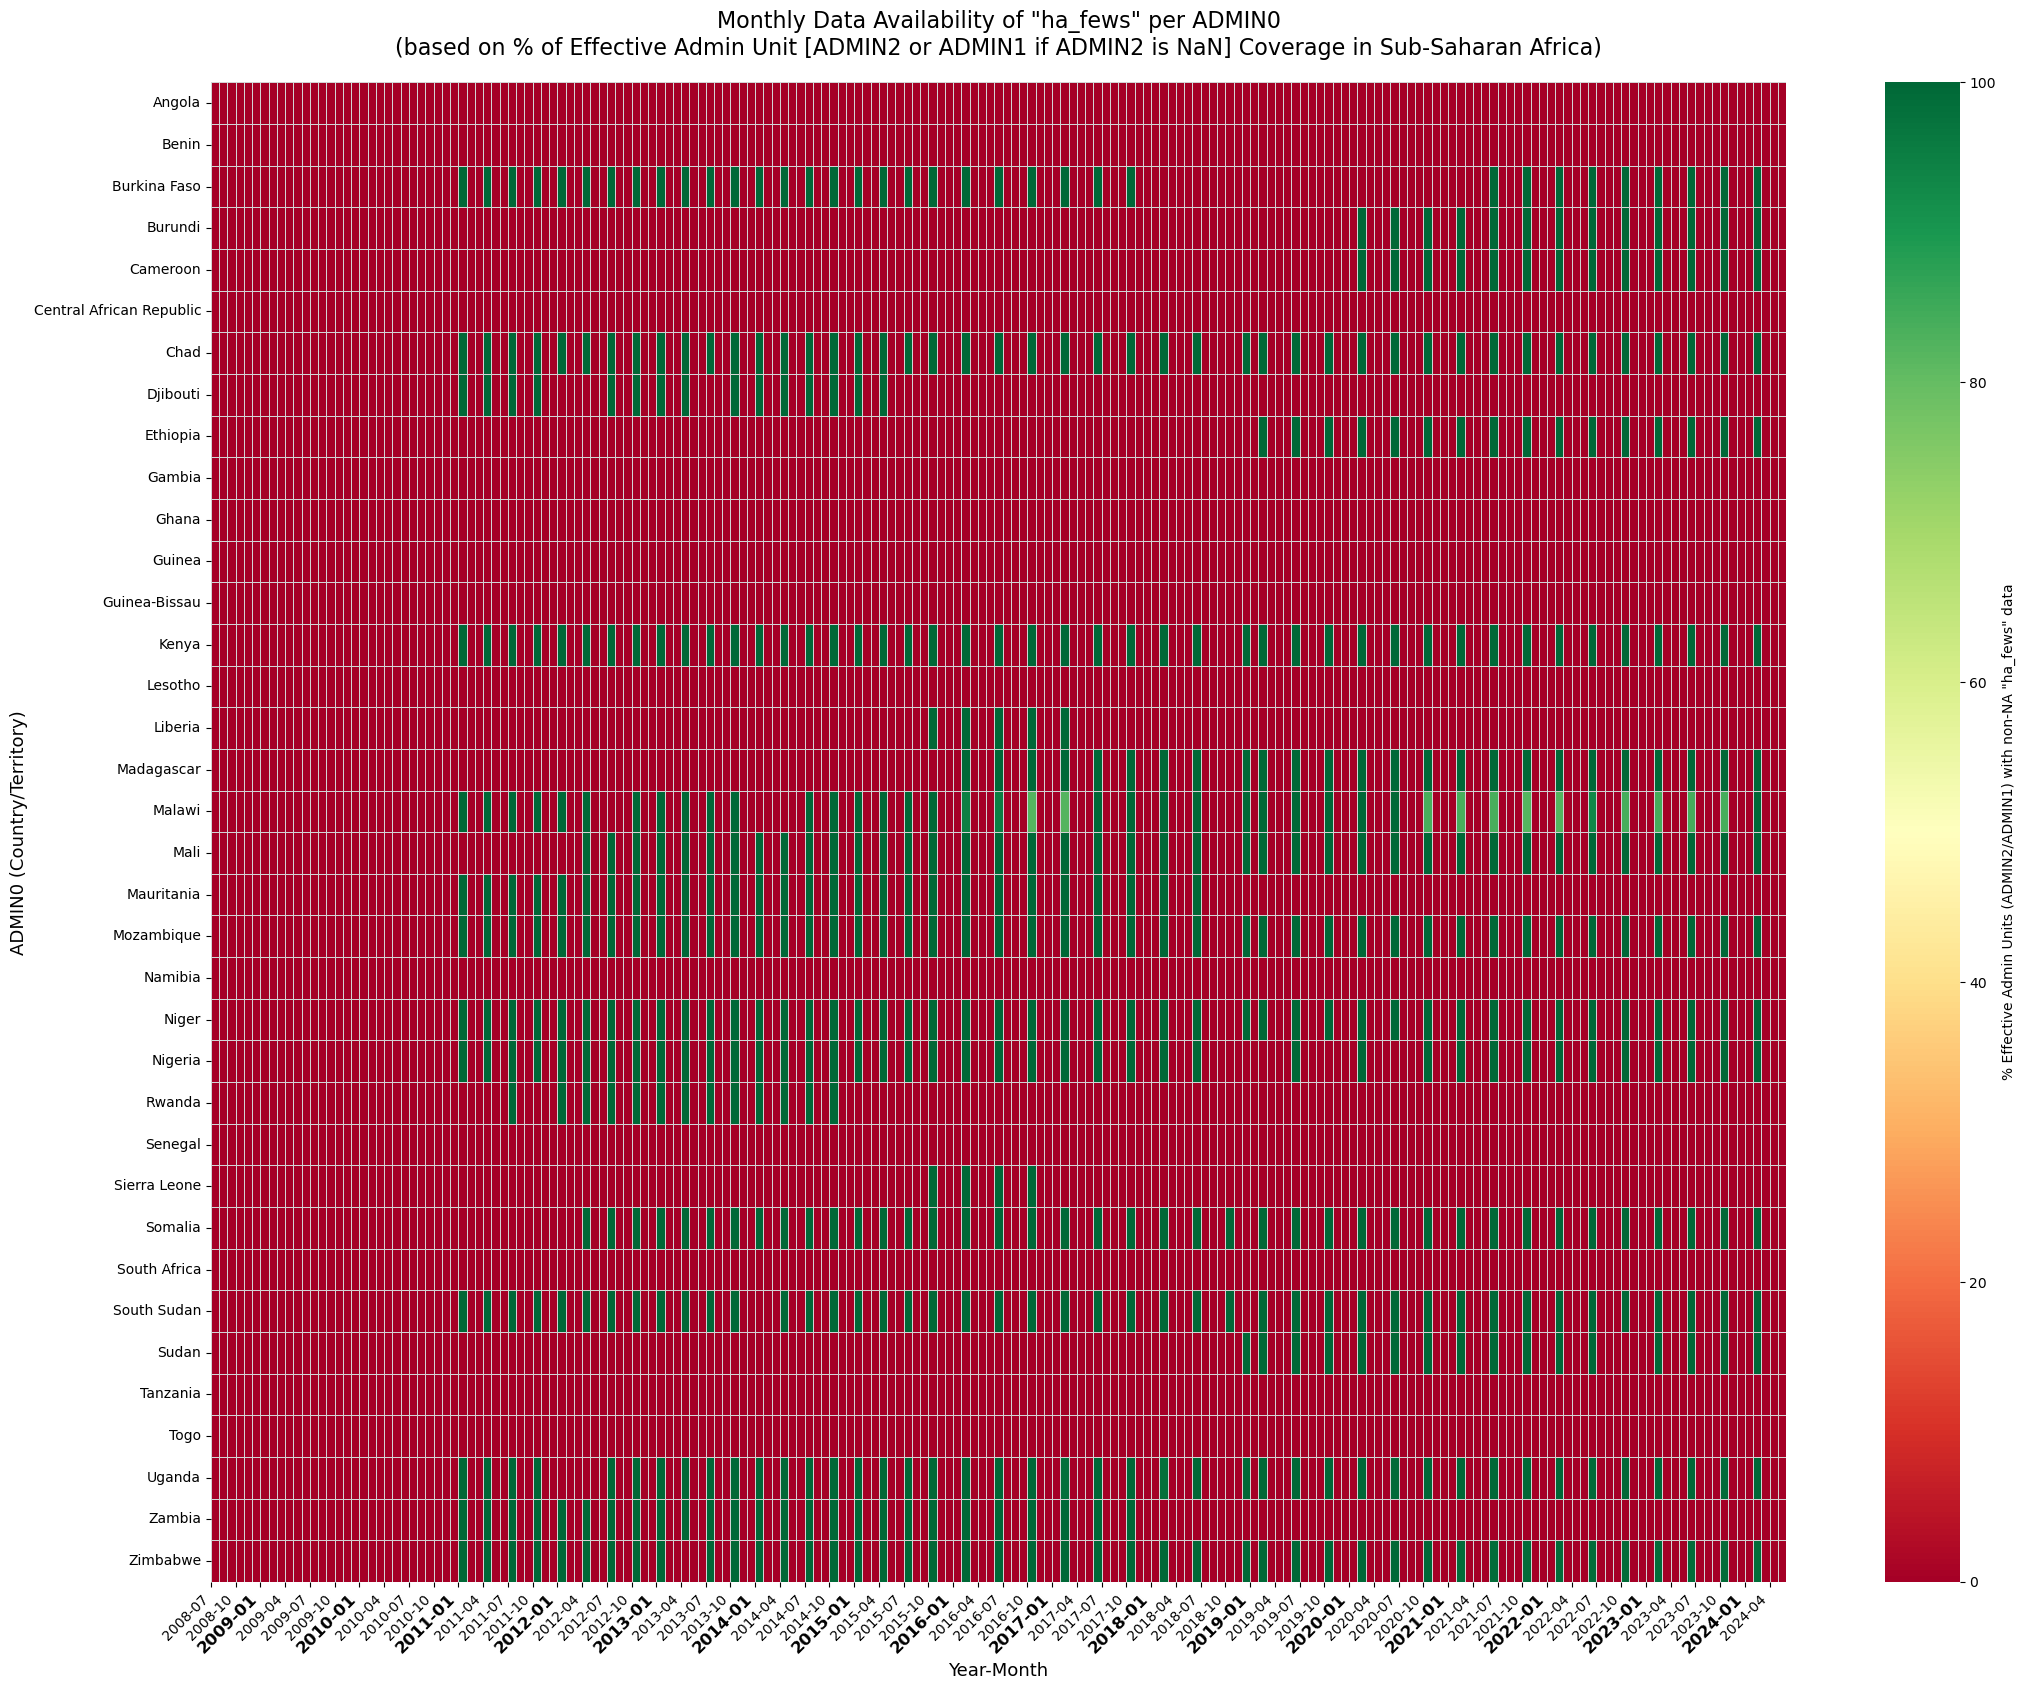

<Figure size 640x480 with 0 Axes>

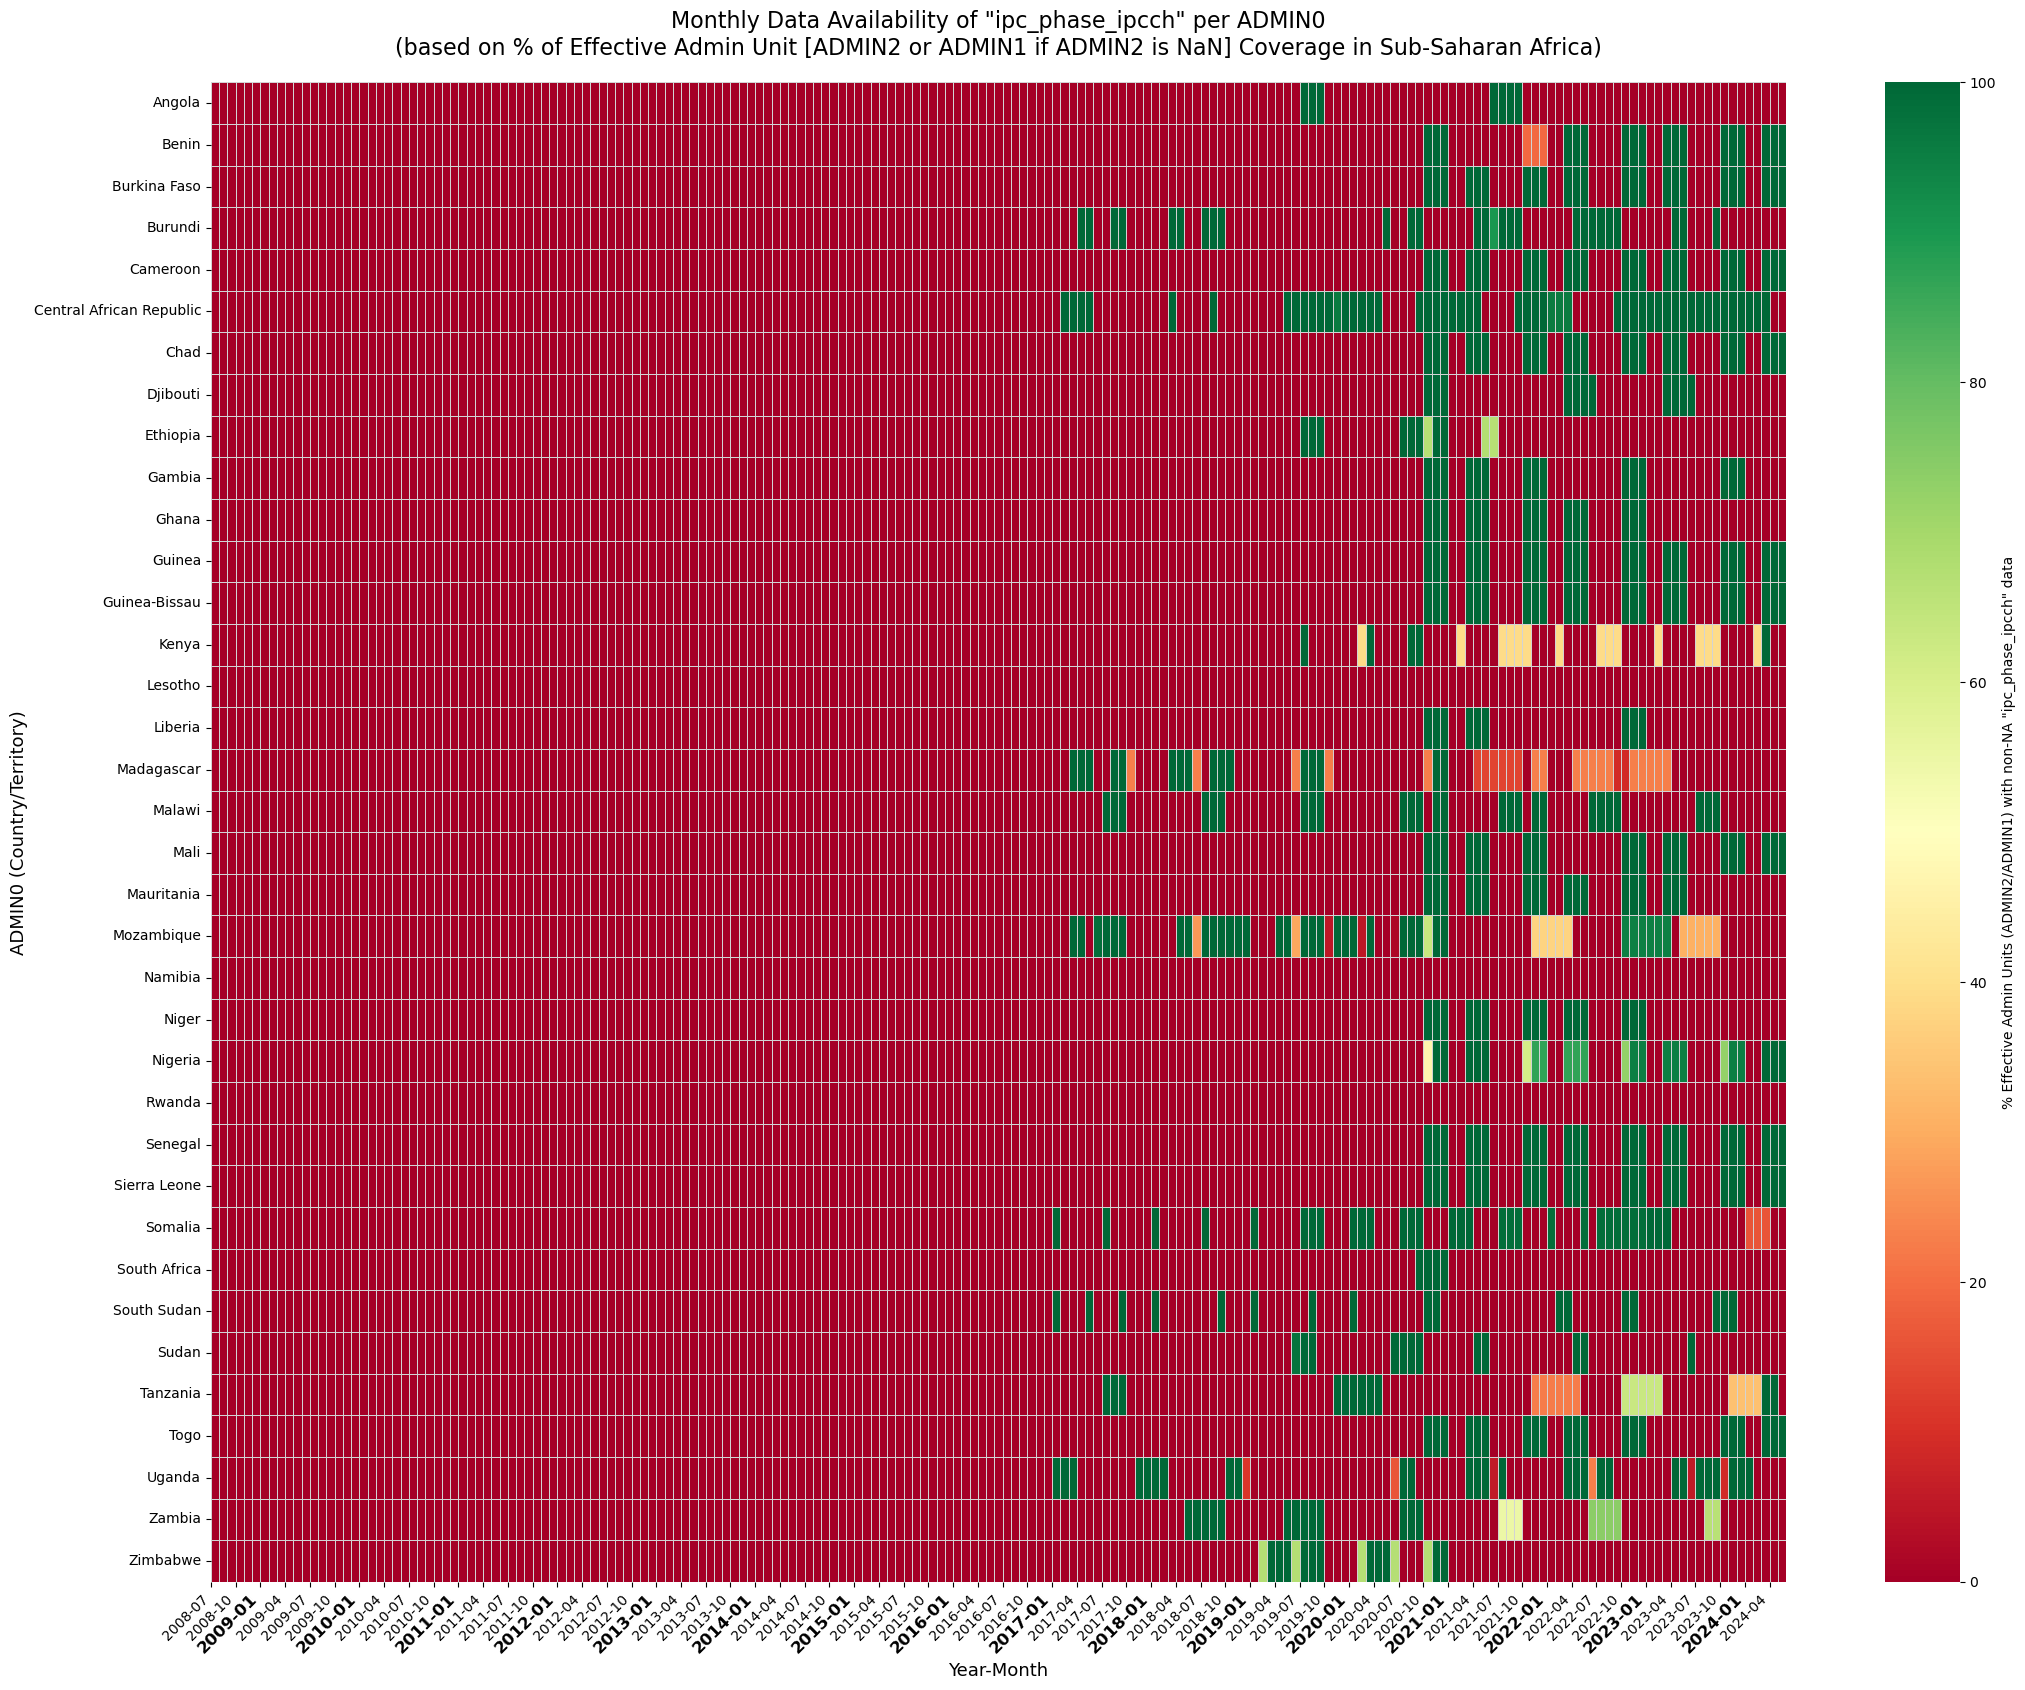

<Figure size 640x480 with 0 Axes>

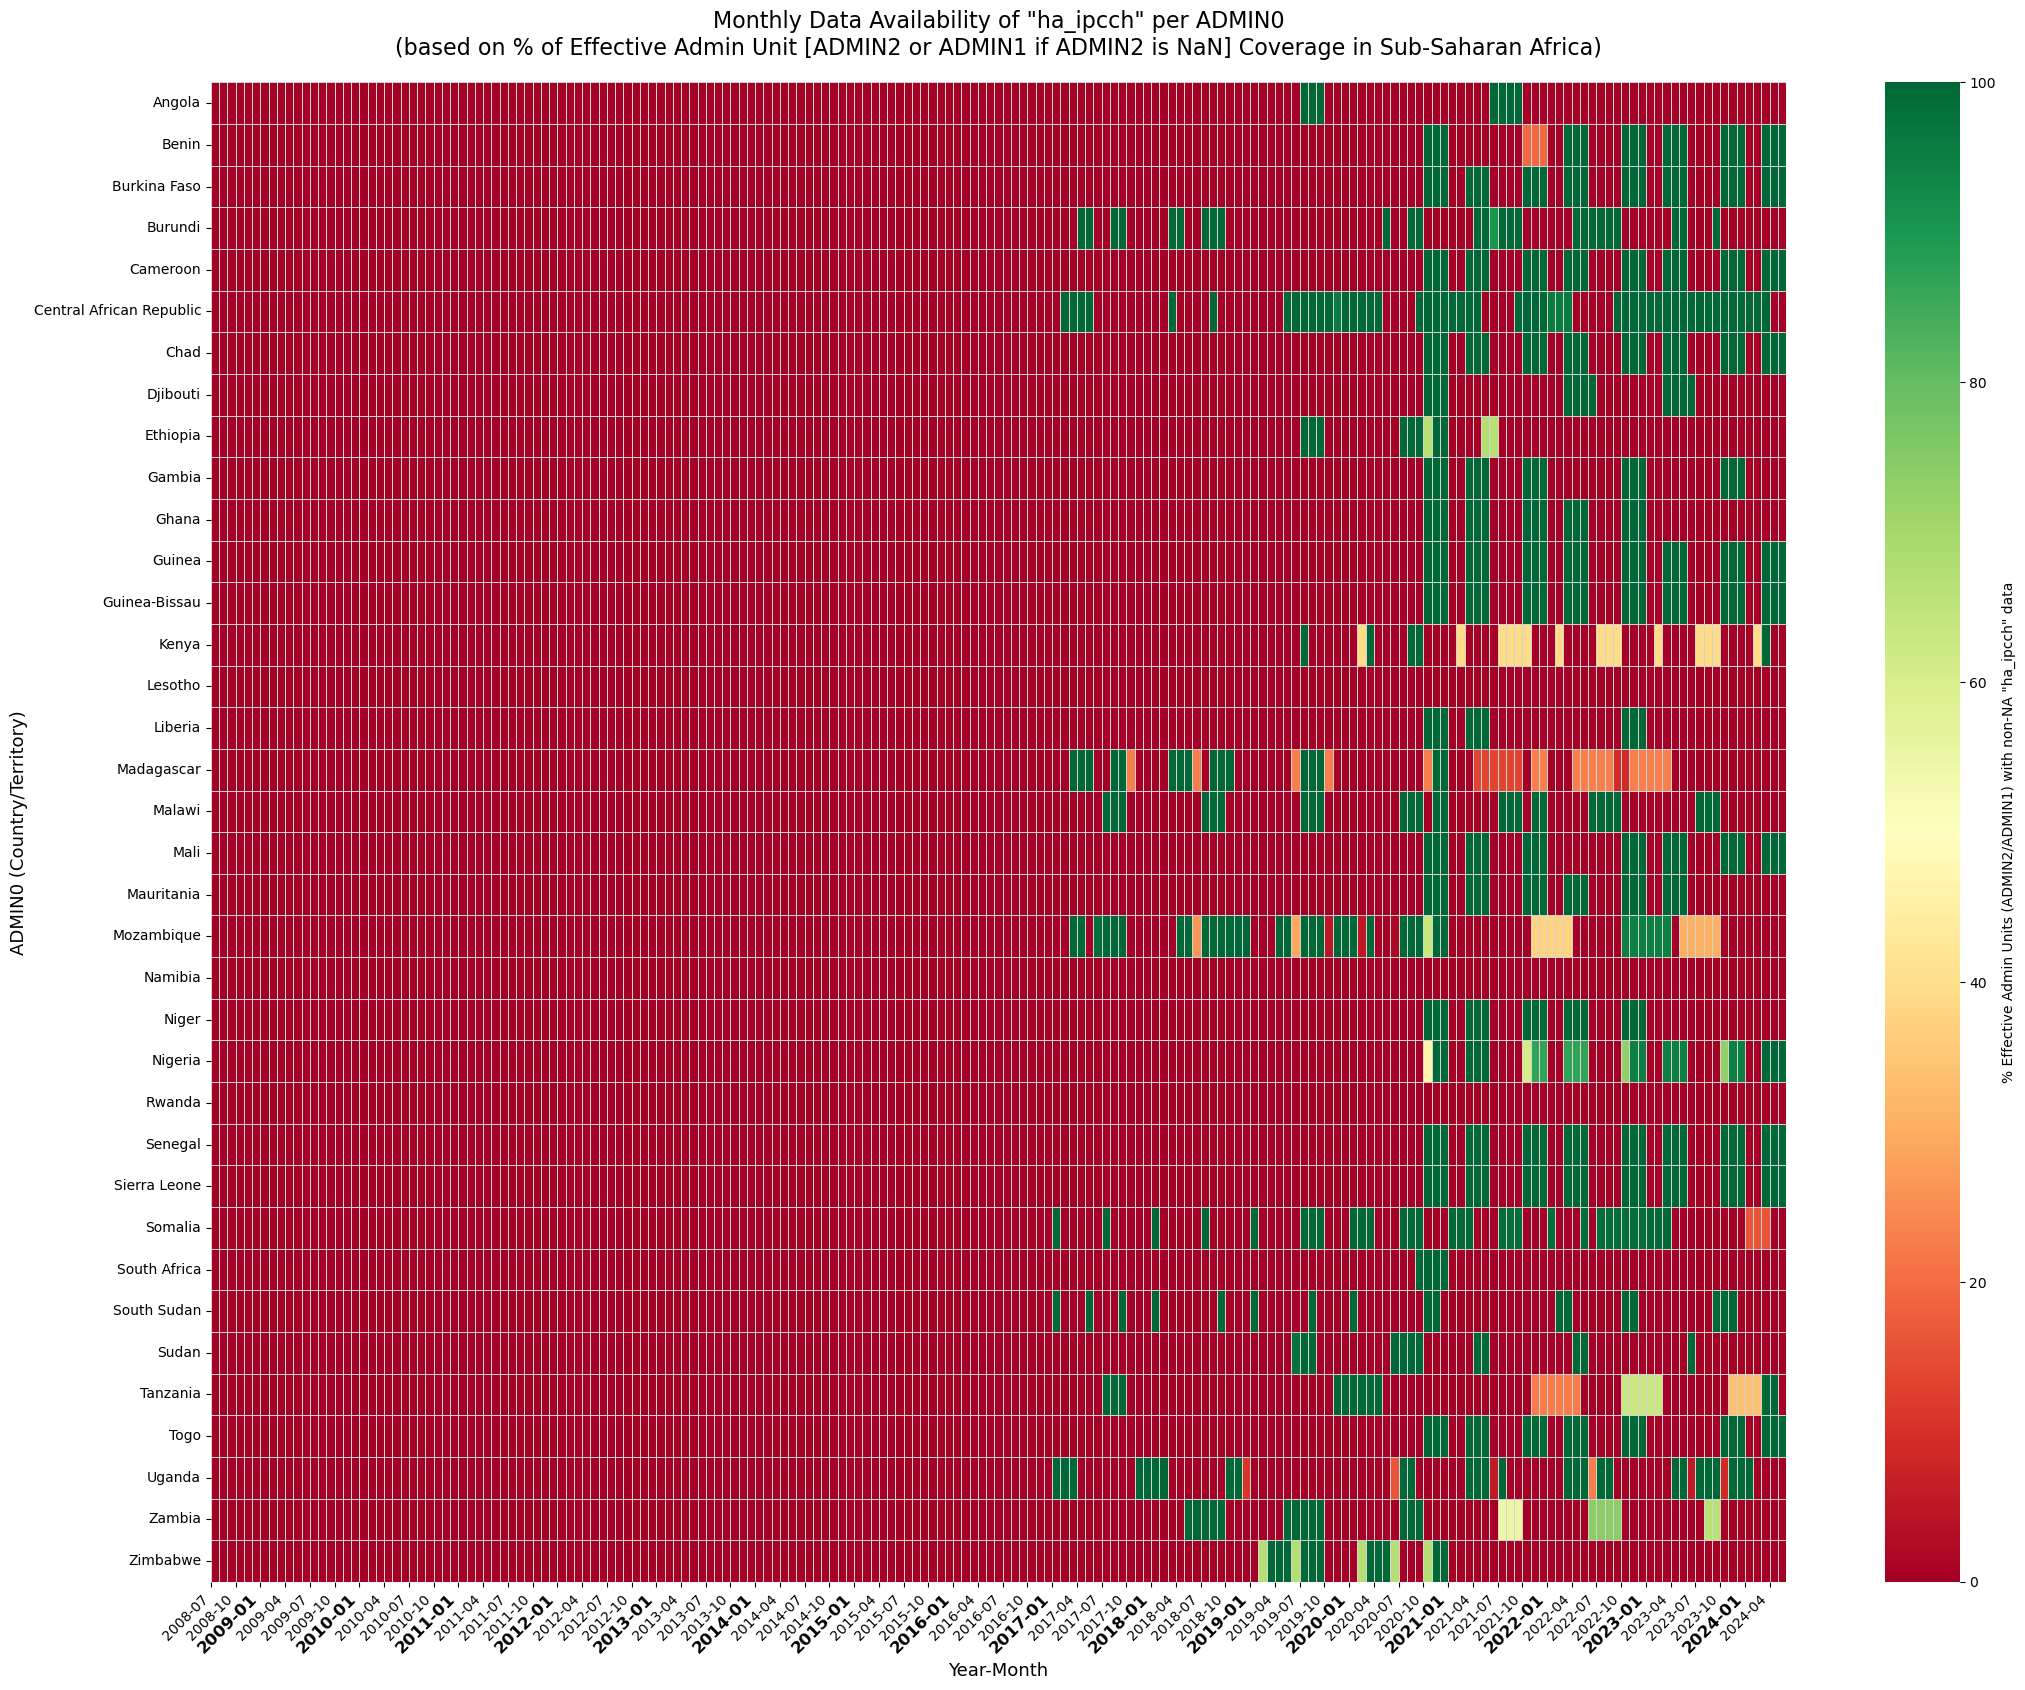

<Figure size 640x480 with 0 Axes>

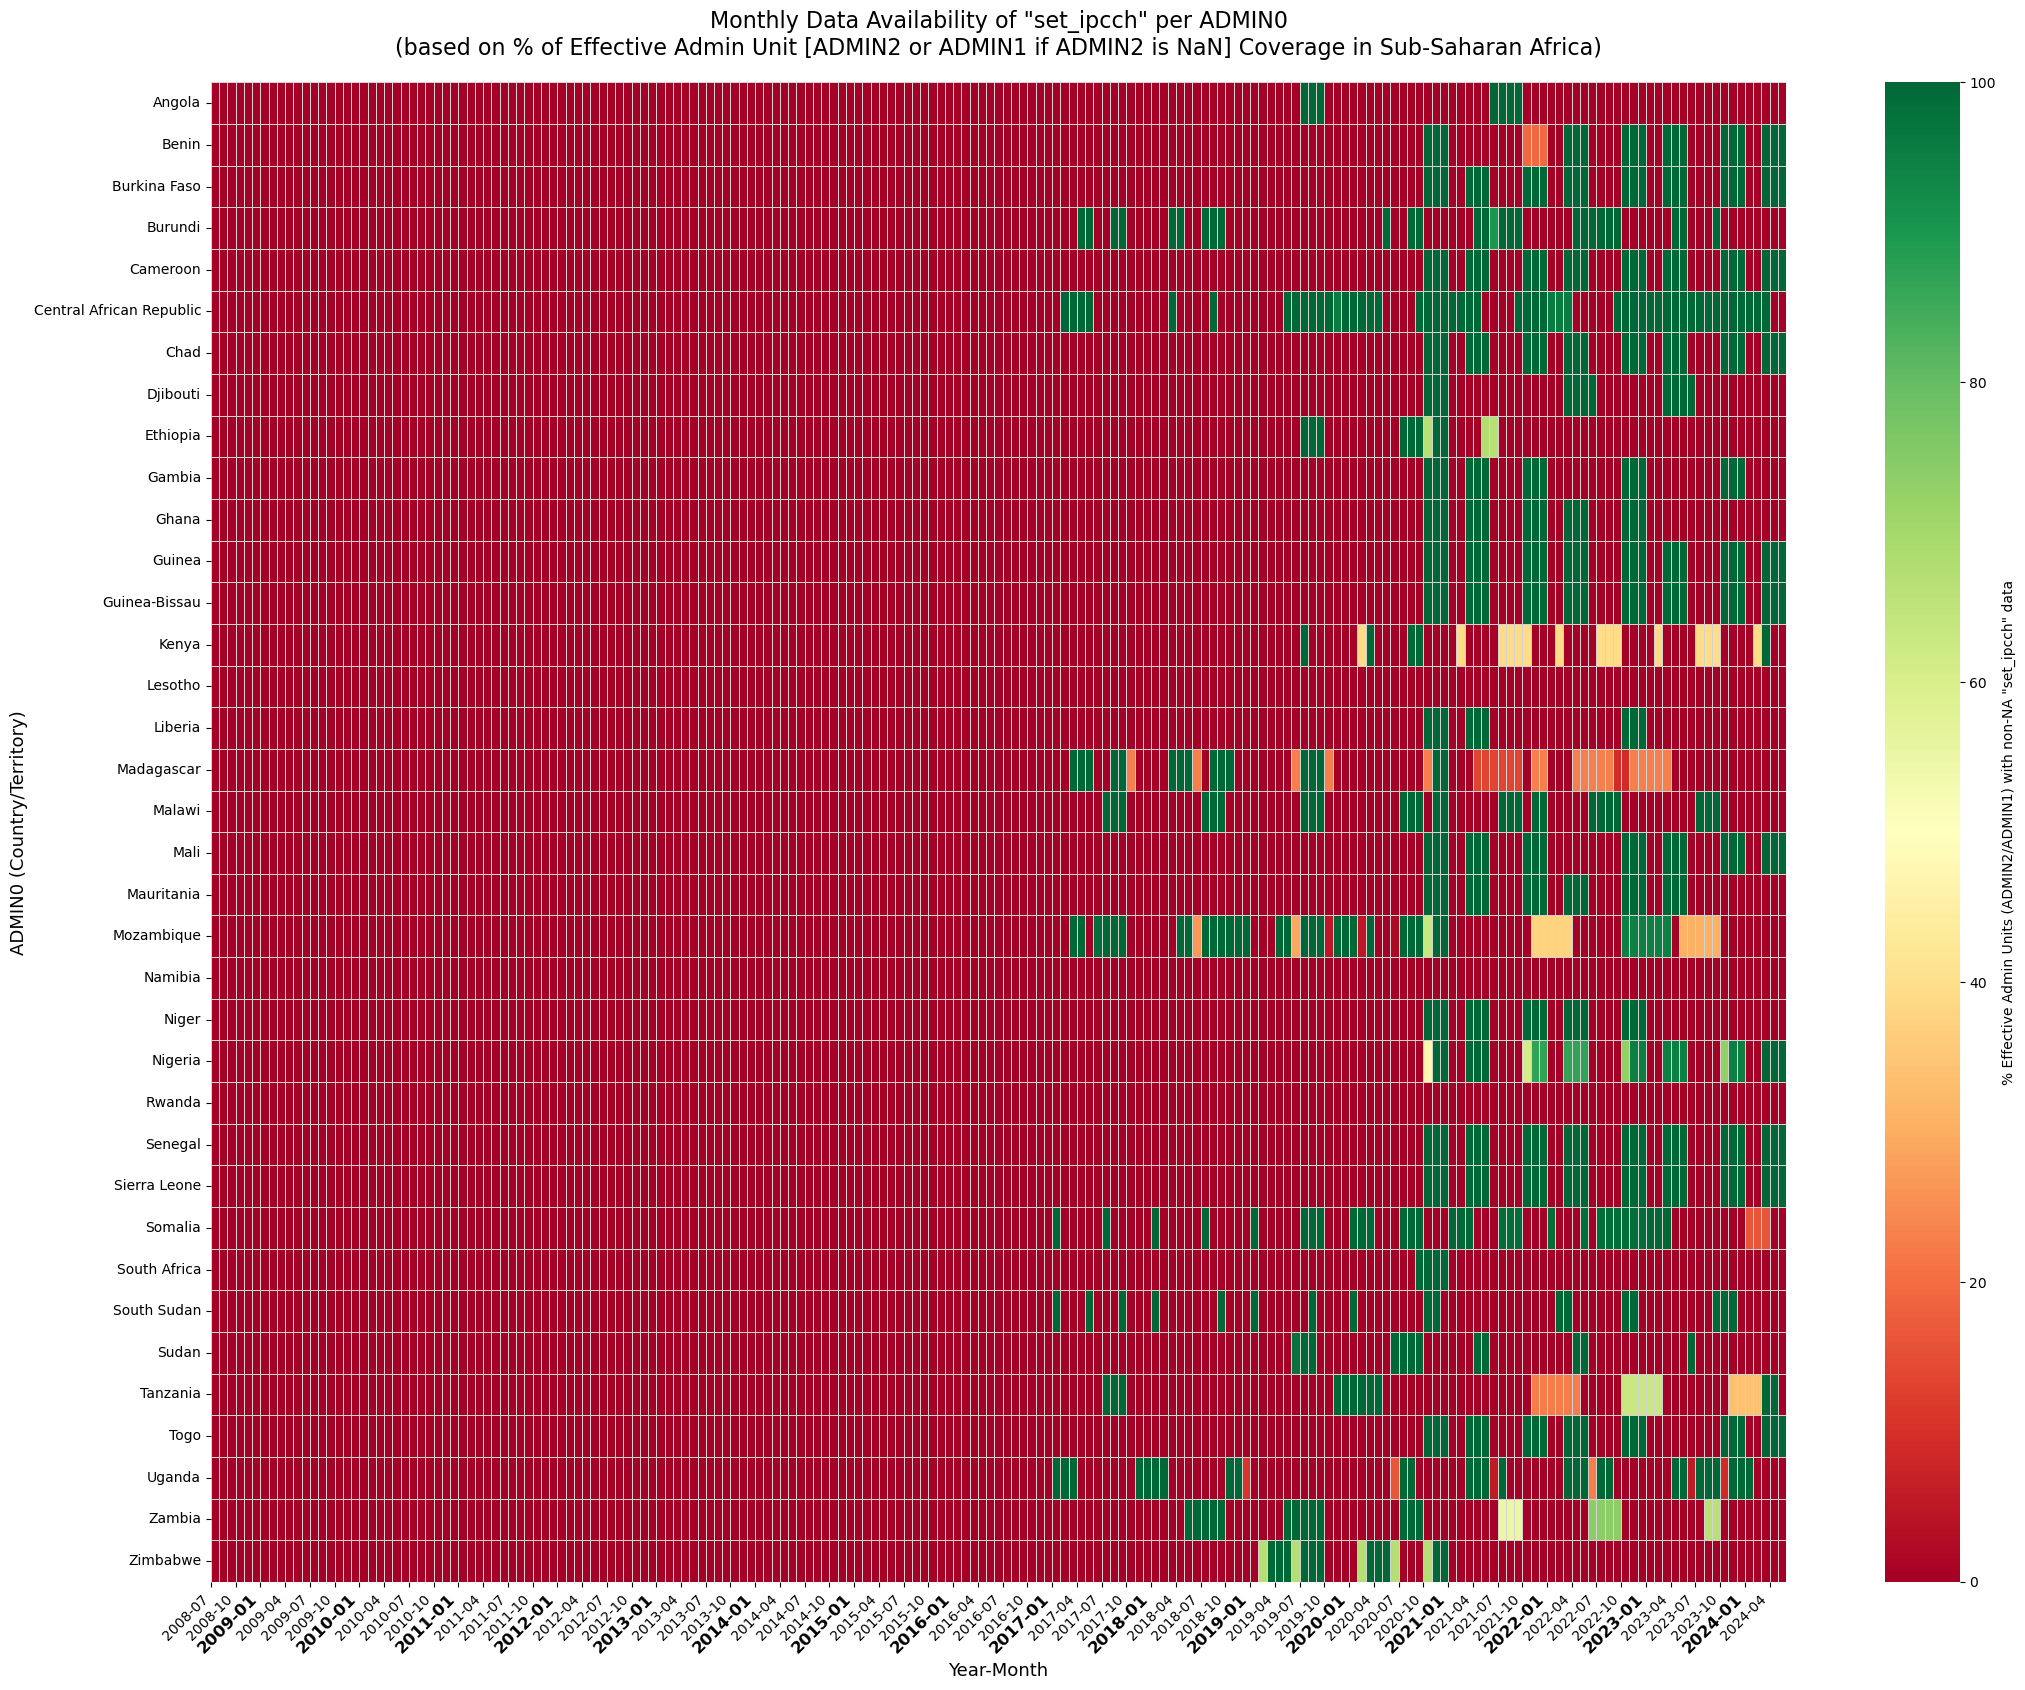

<Figure size 640x480 with 0 Axes>

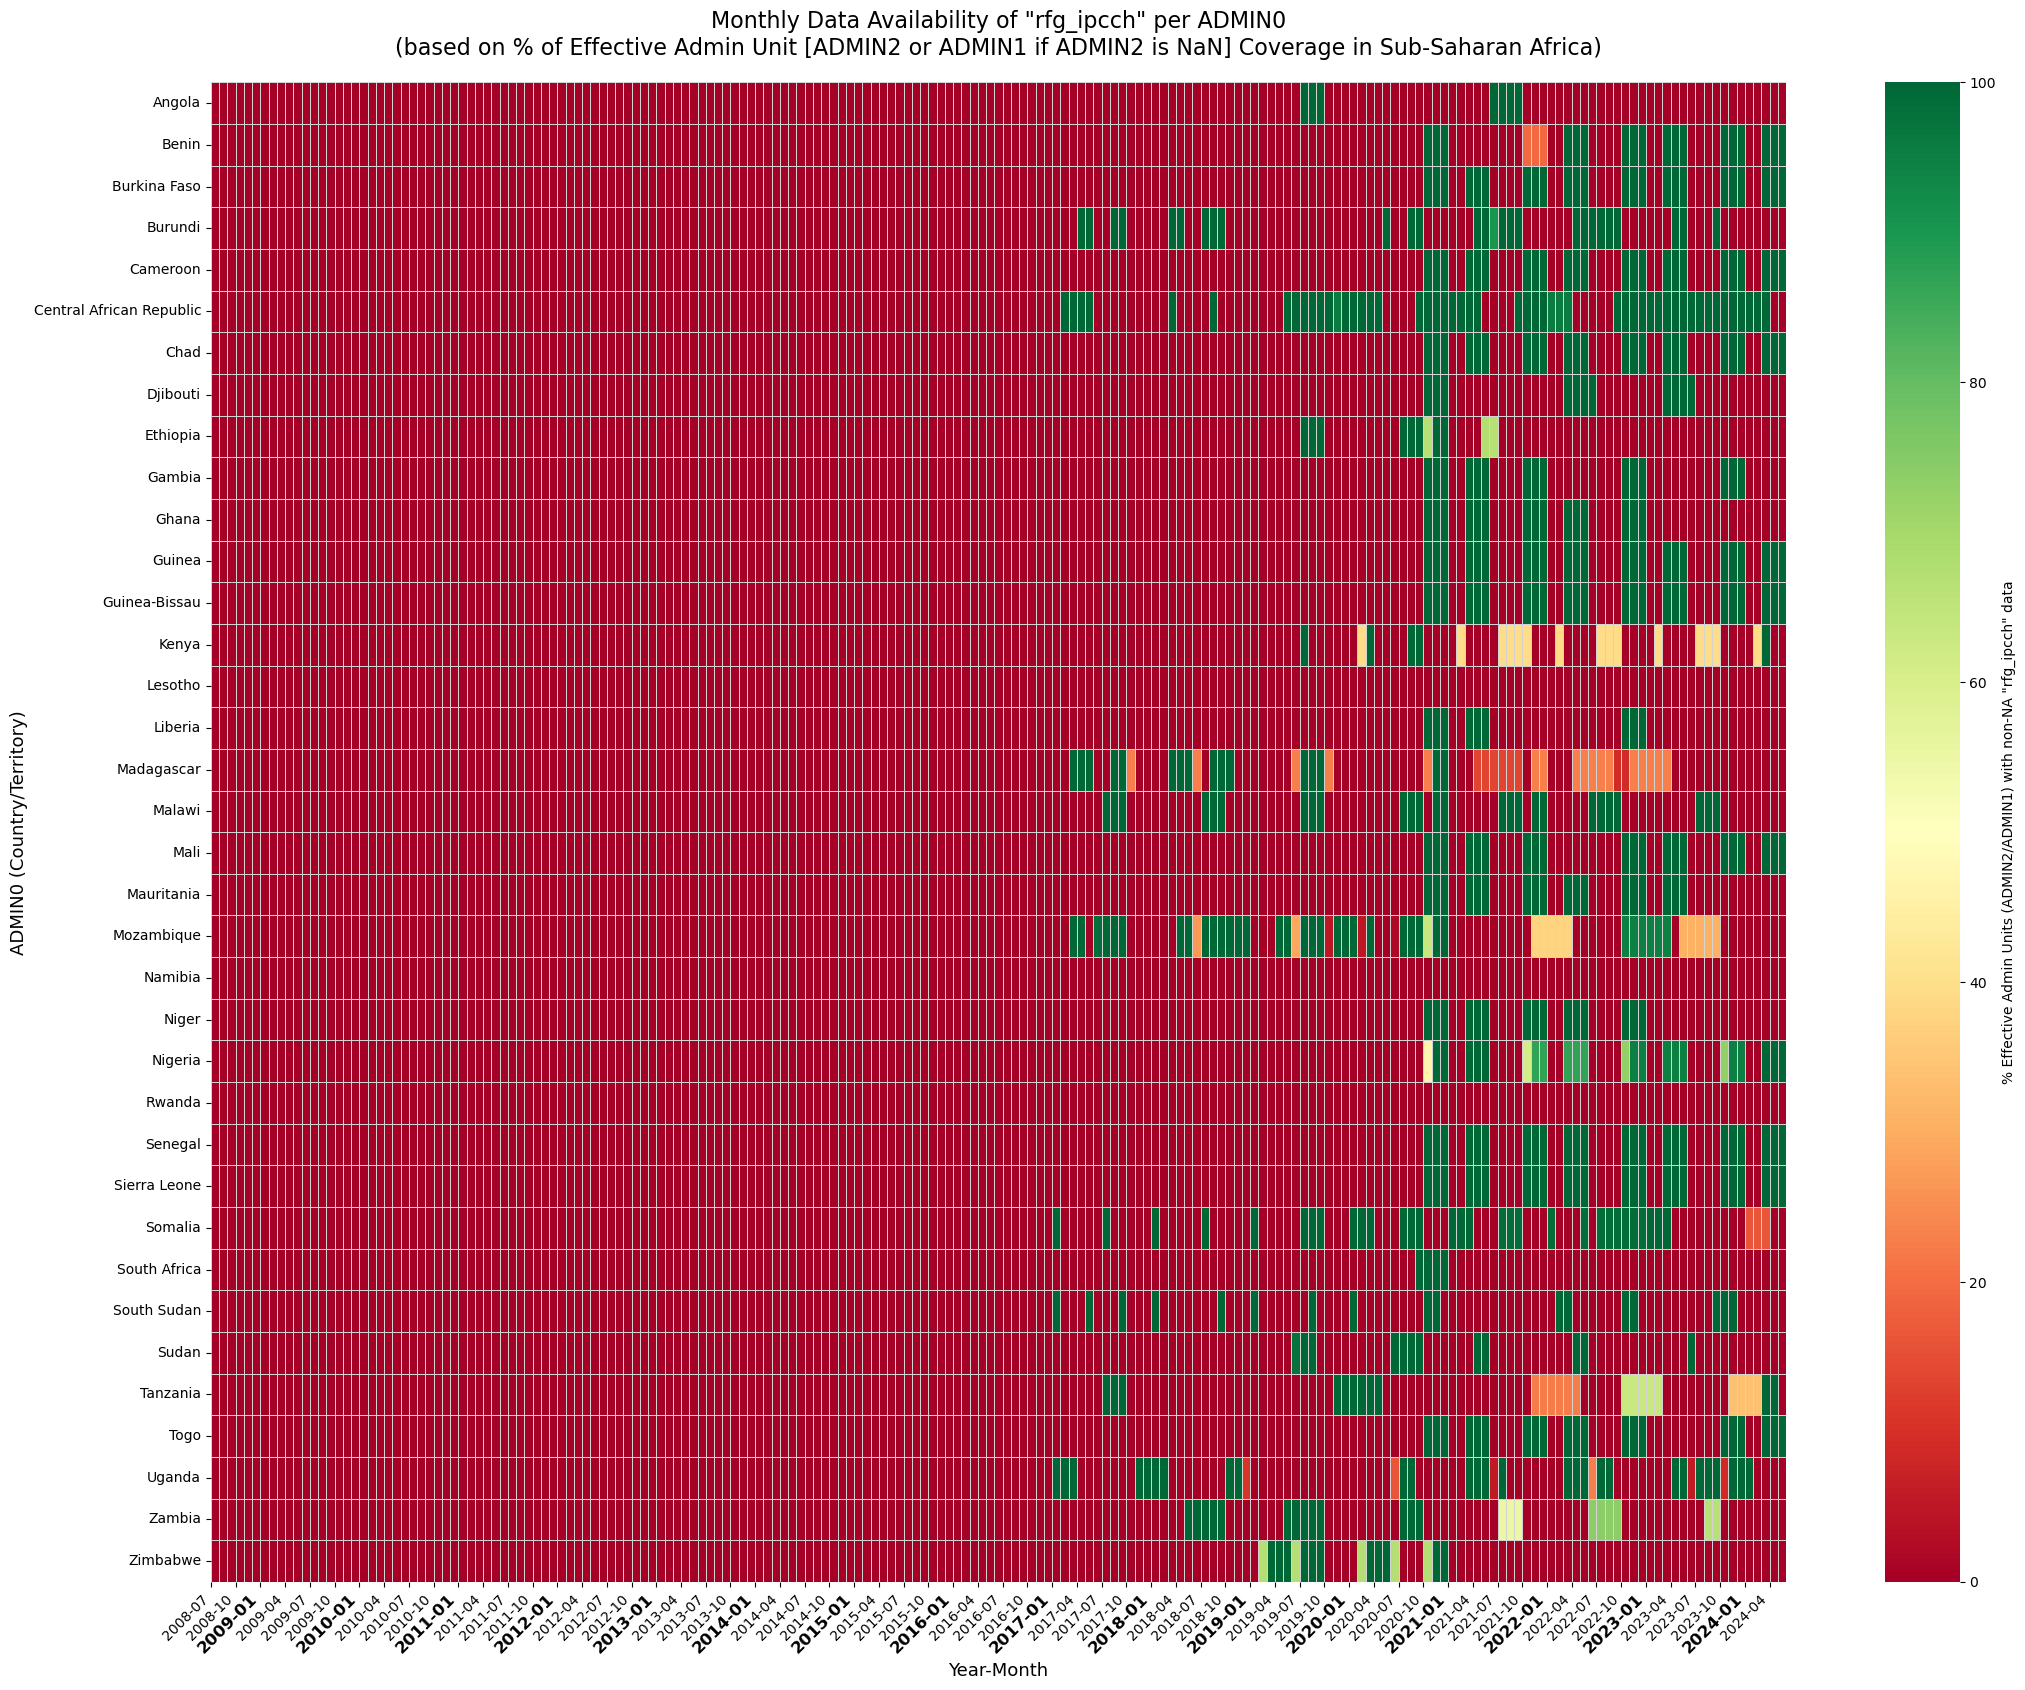

<Figure size 640x480 with 0 Axes>

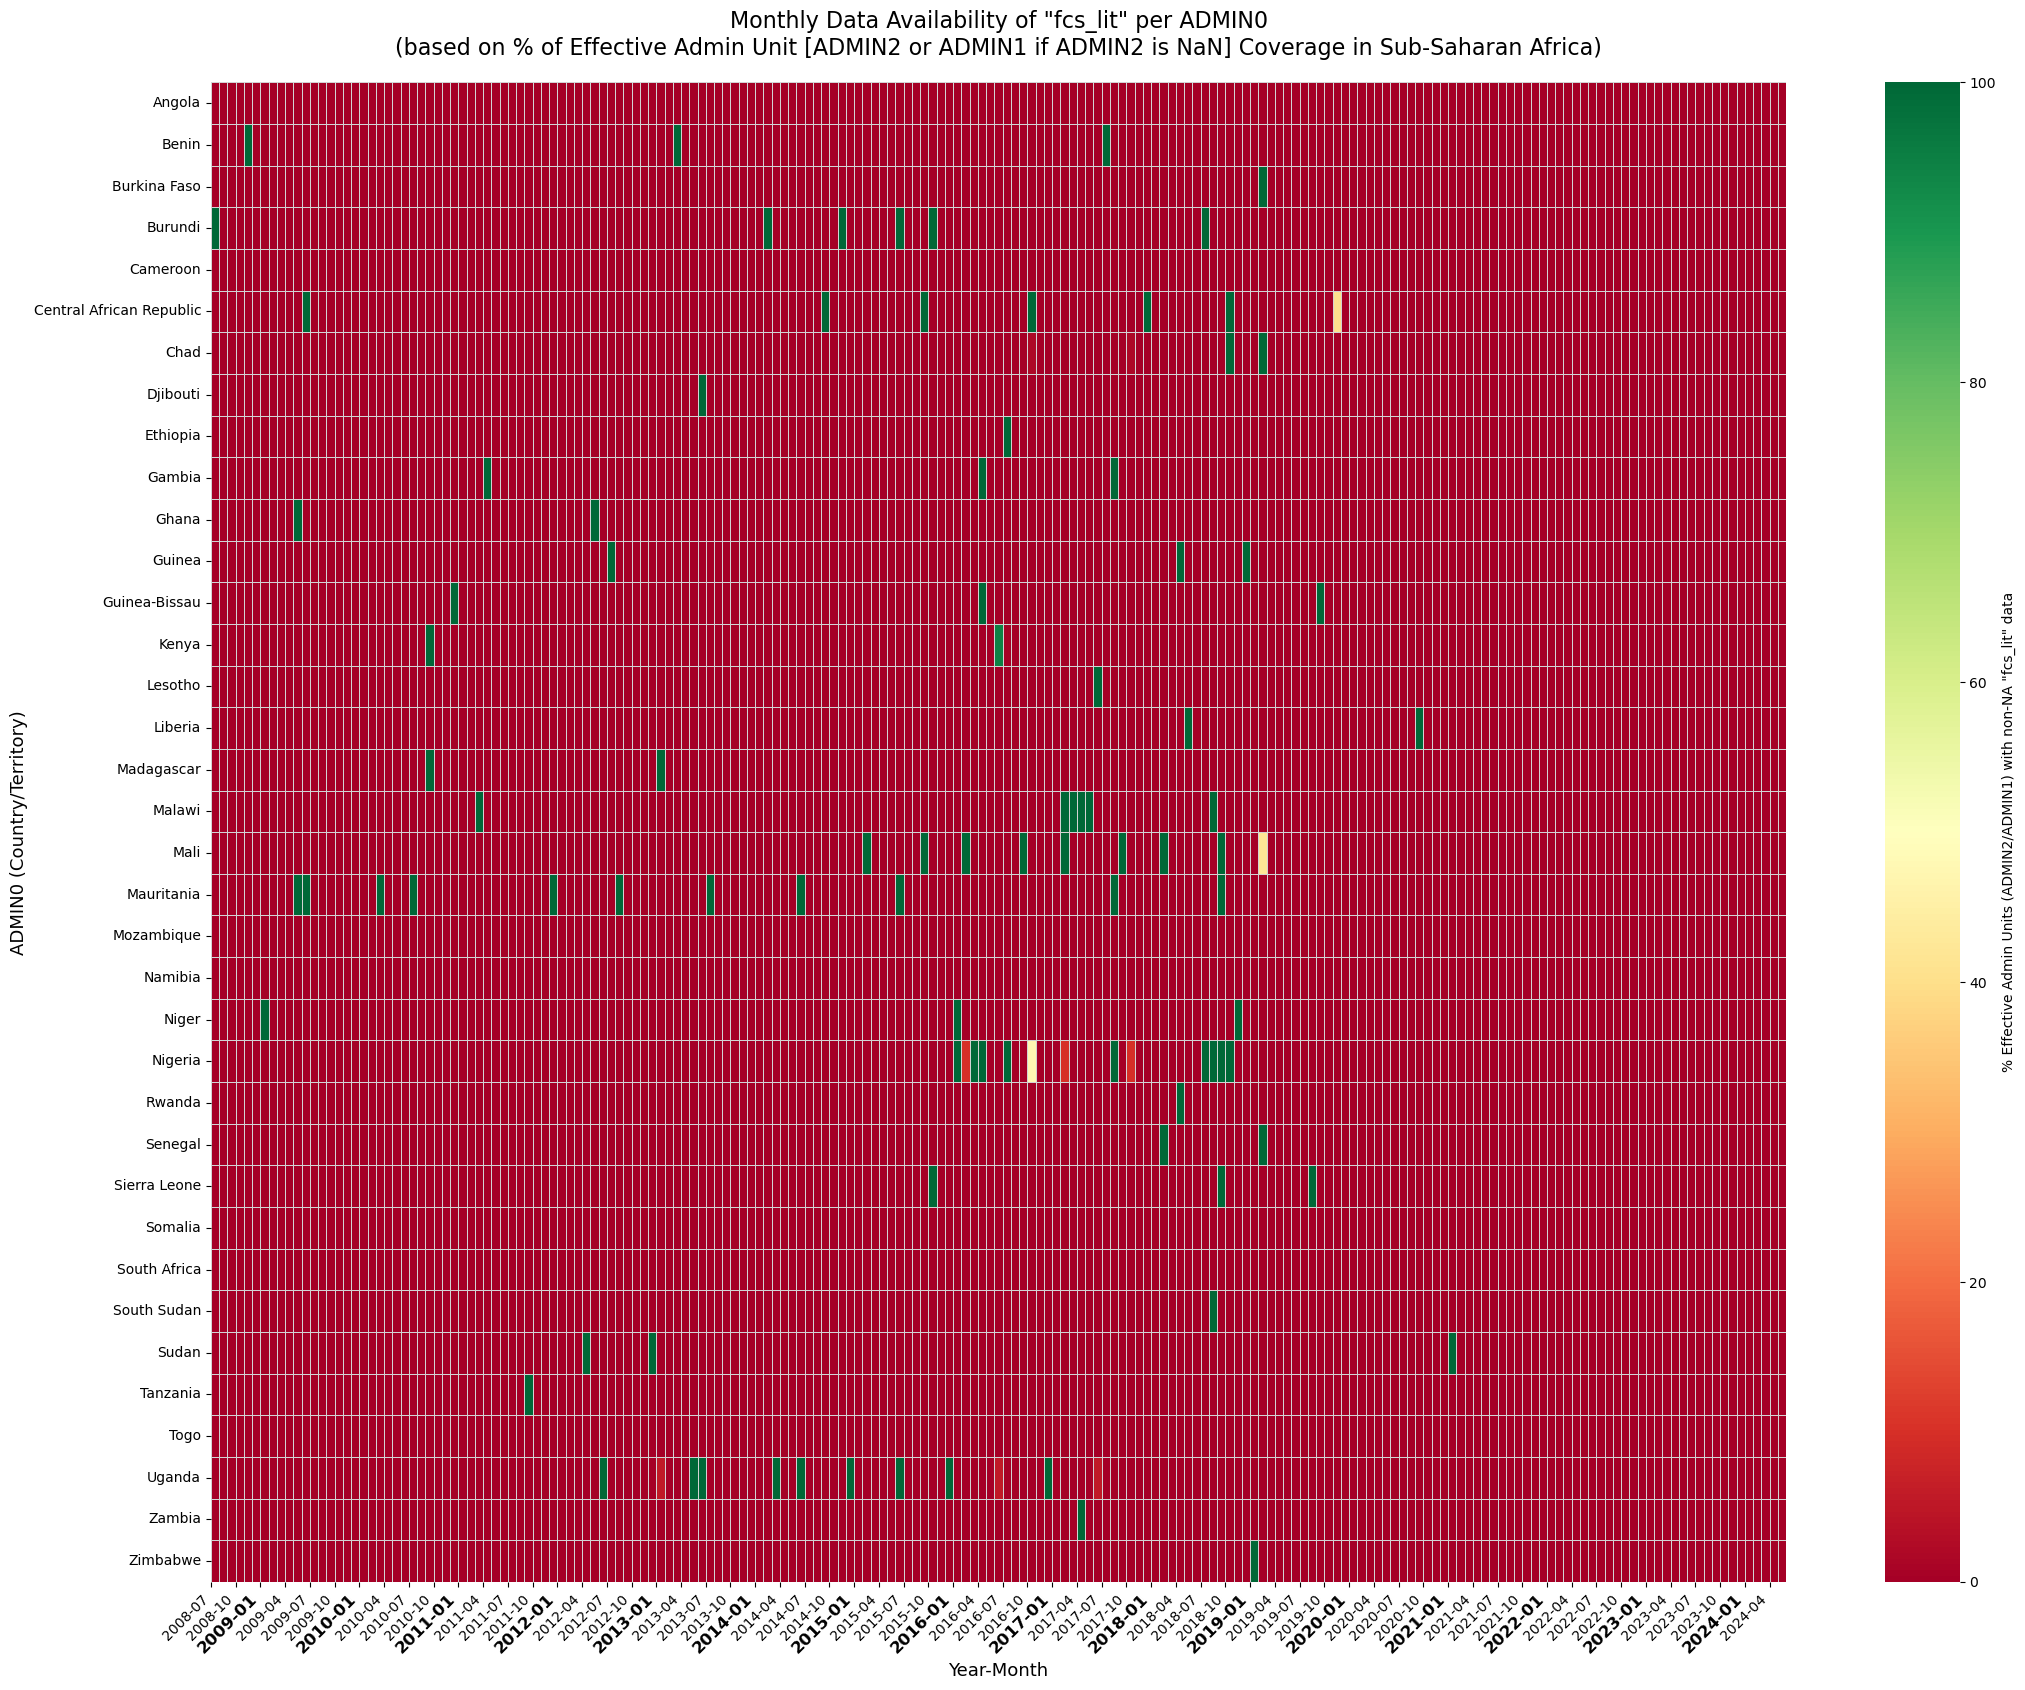

<Figure size 640x480 with 0 Axes>

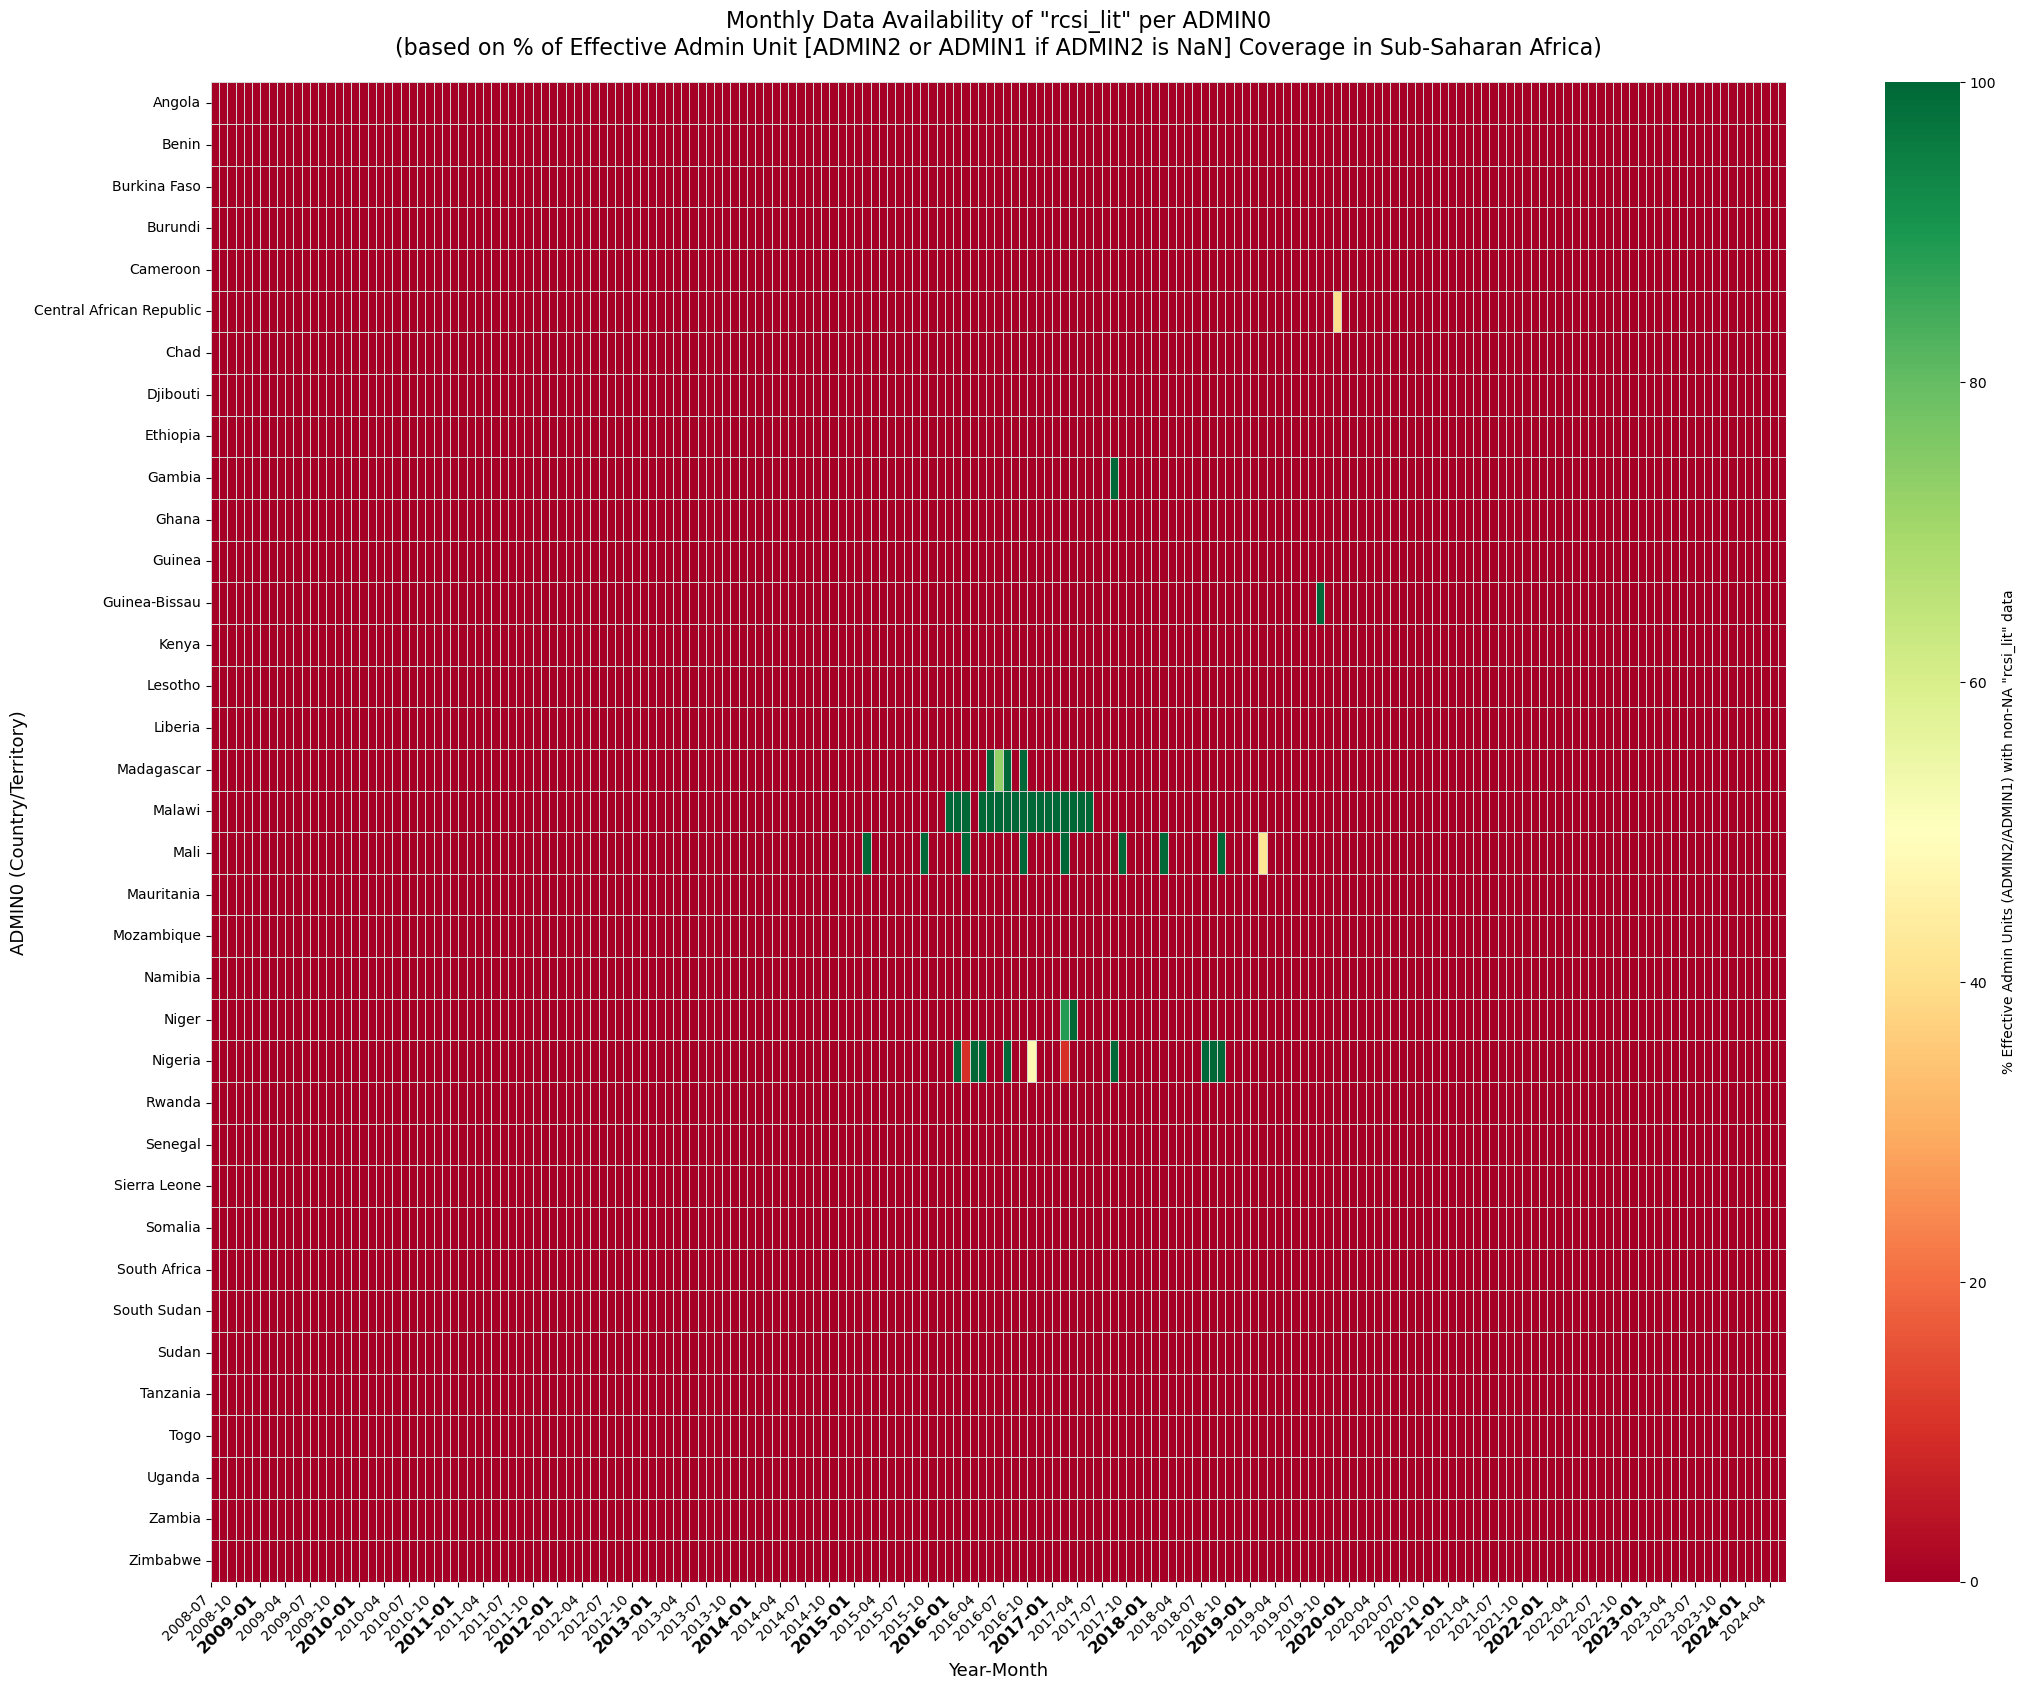

<Figure size 640x480 with 0 Axes>

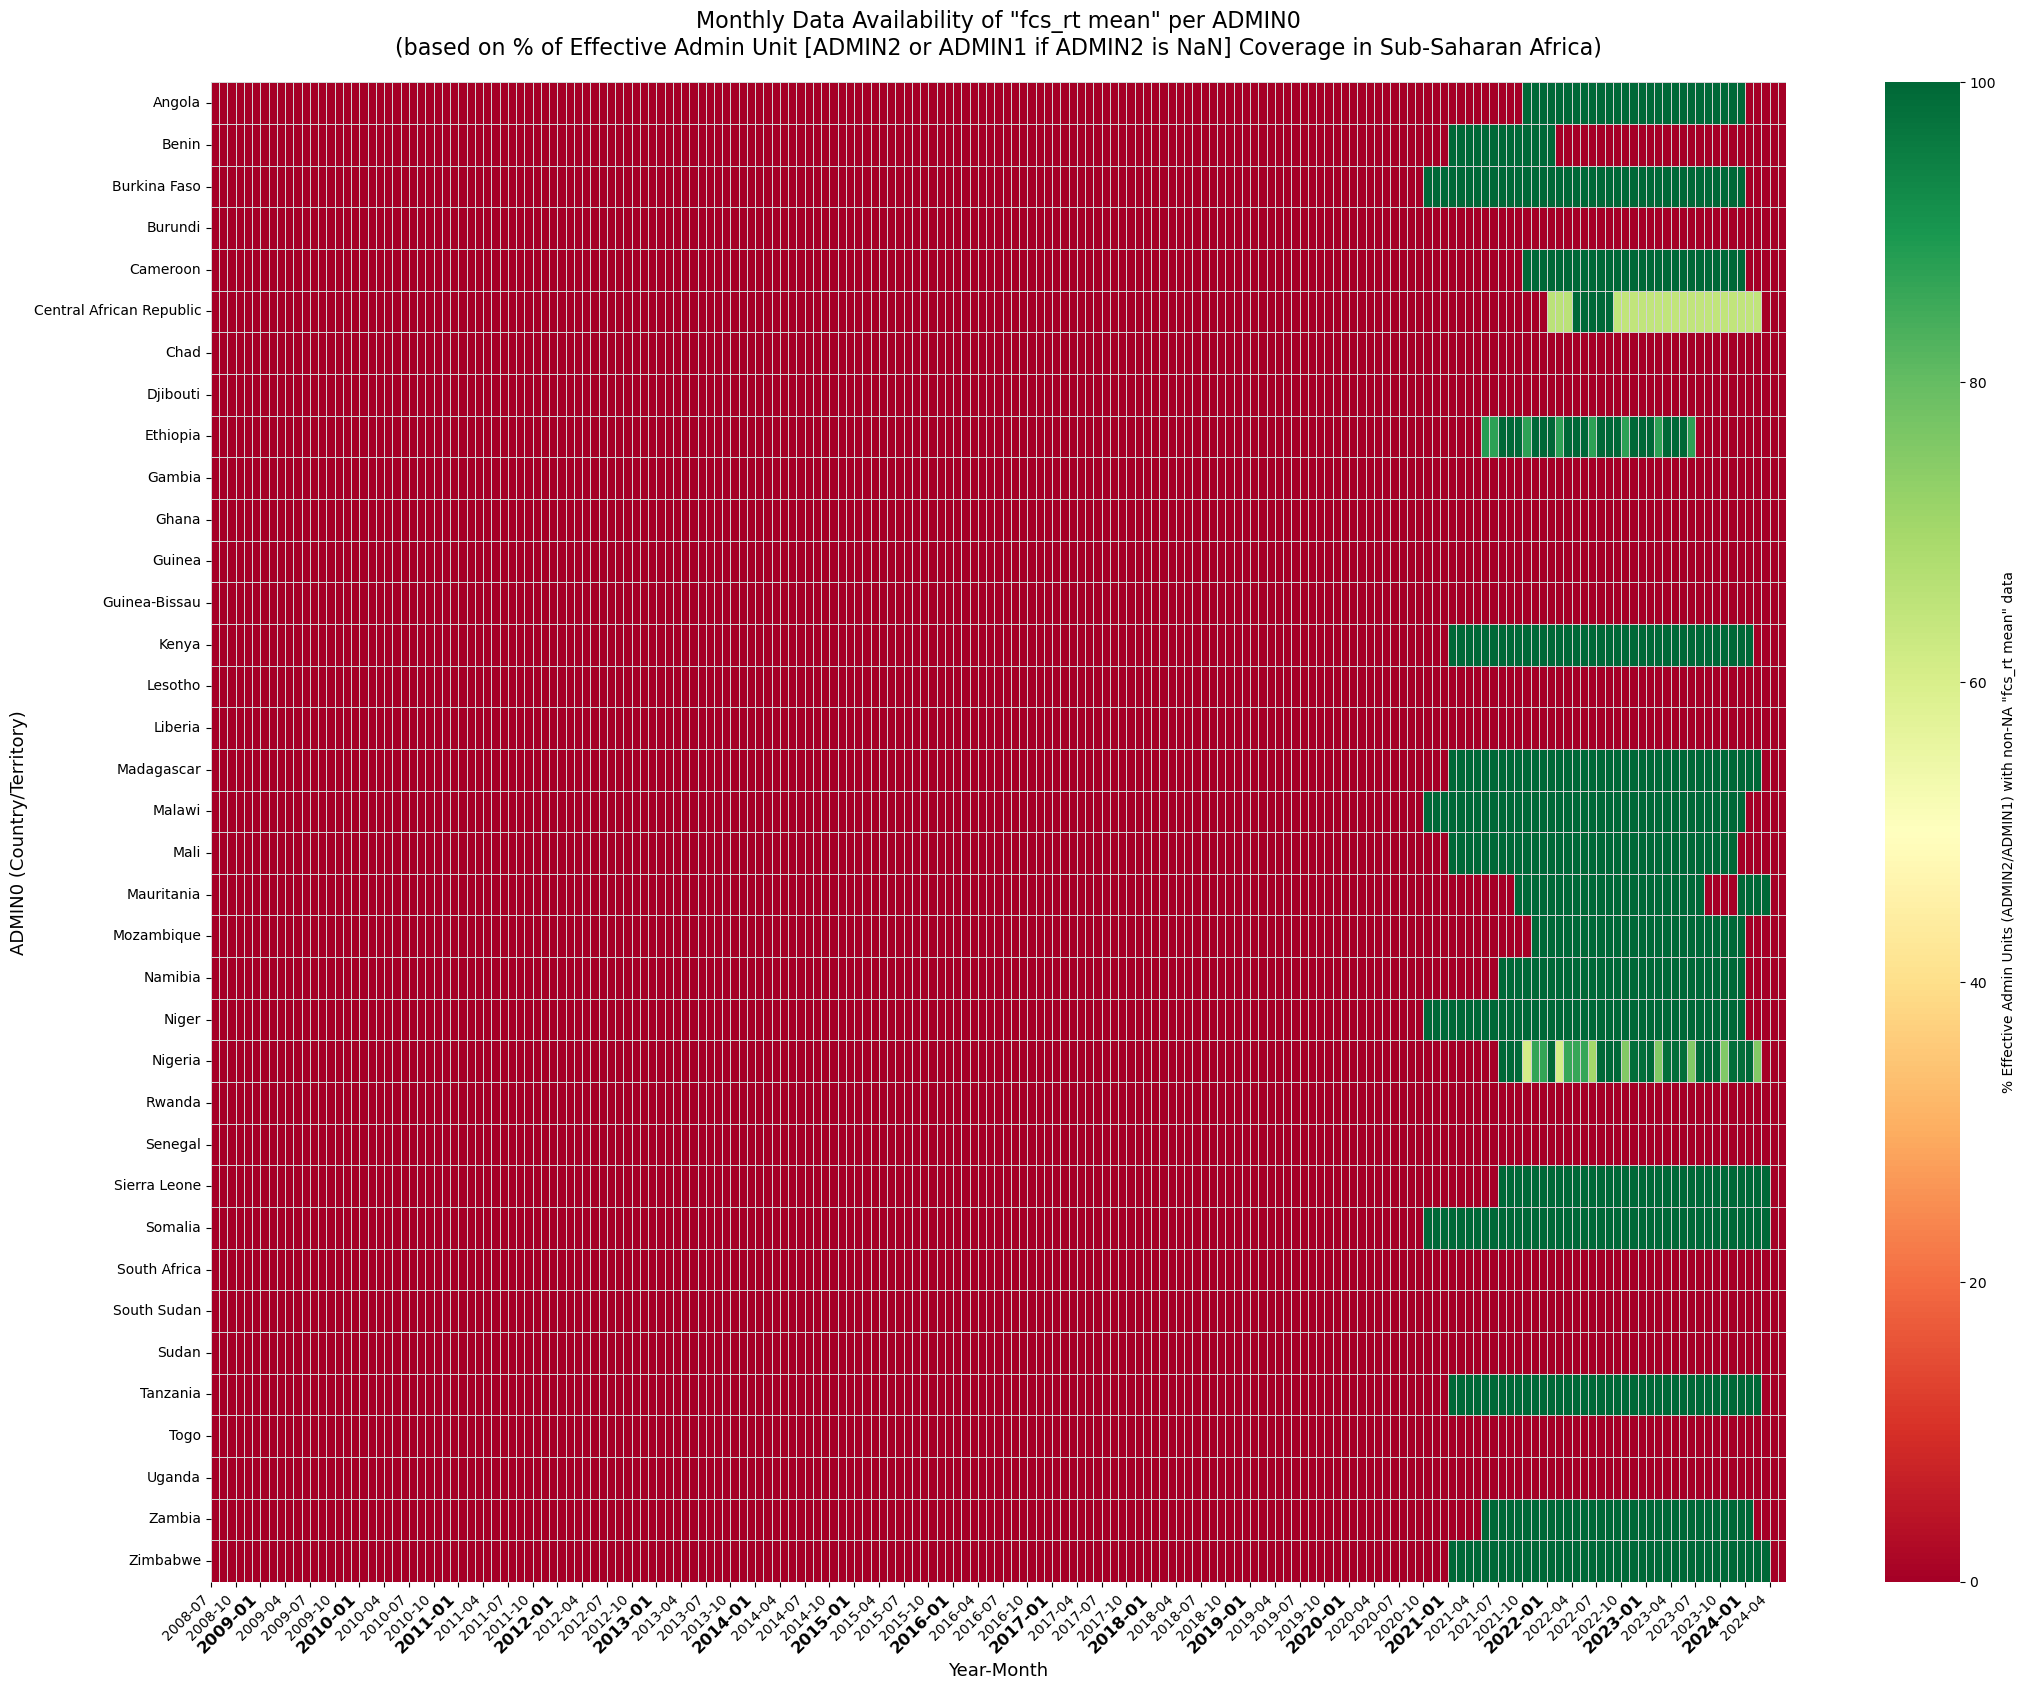

<Figure size 640x480 with 0 Axes>

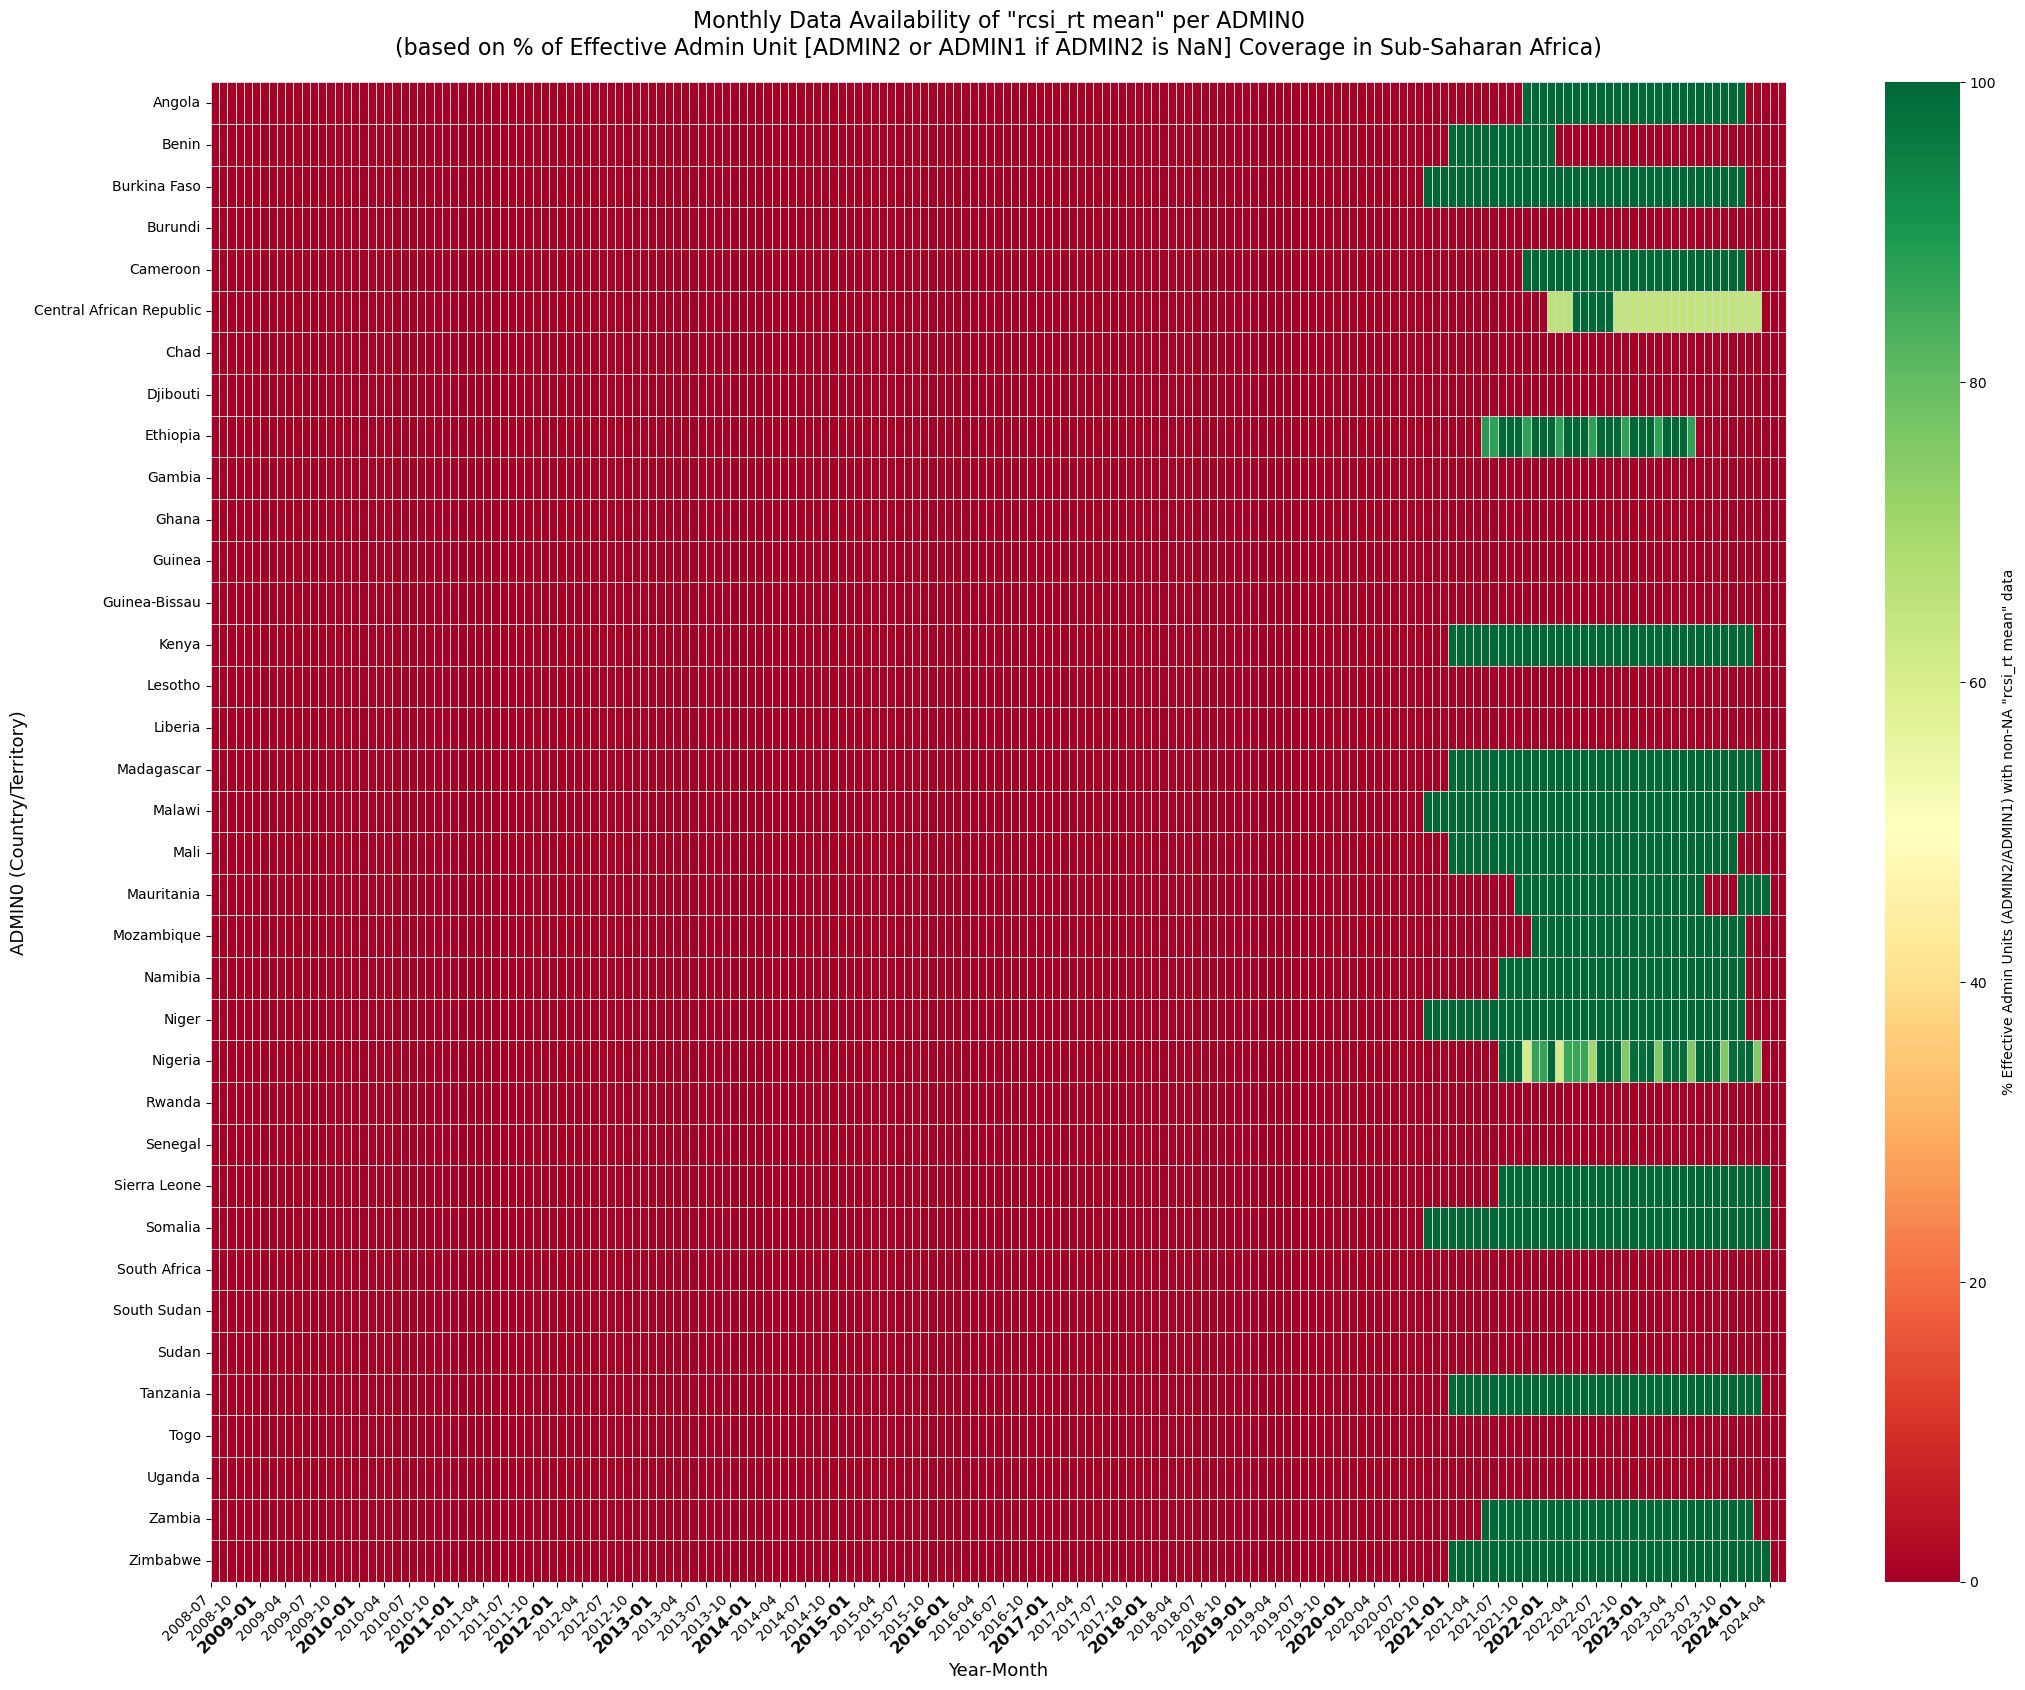

<Figure size 640x480 with 0 Axes>

In [10]:
import seaborn as sns
# Ensure 'fs_data_harmonized' and 'sub_saharan_africa_list' are available from previous cells.
# Required imports: pandas as pd, matplotlib.pyplot as plt, seaborn as sns, numpy as np (assumed from previous cells)

indicators_to_plot = [
    'ipc_phase_fews', 'ha_fews', 'ipc_phase_ipcch', 'ha_ipcch',
    'set_ipcch', 'rfg_ipcch', 'fcs_lit', 'rcsi_lit',
    'fcs_rt mean', 'rcsi_rt mean'
]
import country_converter as coco
cc = coco.CountryConverter()
# Define font sizes for ticks
REGULAR_TICK_FONTSIZE = 10
JANUARY_TICK_FONTSIZE = 12 # Larger font size for January ticks

for indicator_col in indicators_to_plot:
    # Create a working copy and filter for Sub-Saharan Africa
    df_ssa_analysis = fs_data_harmonized[fs_data_harmonized['ADMIN0'].isin(list(map(lambda x: cc.convert(x, to='name_short'),sub_saharan_africa_list)))].copy()

    # Create the 'effective_admin_unit' column
    df_ssa_analysis['effective_admin_unit'] = df_ssa_analysis['ADMIN2'].fillna(df_ssa_analysis['ADMIN1'])

    # Drop rows where 'effective_admin_unit' is NaN
    df_ssa_analysis.dropna(subset=['effective_admin_unit'], inplace=True)

    # Ensure 'year_month' is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(df_ssa_analysis['year_month']):
        df_ssa_analysis['year_month'] = pd.to_datetime(df_ssa_analysis['year_month'])

    # Calculate total unique effective_admin_units
    total_units_per_group = df_ssa_analysis.groupby(['ADMIN0', 'year_month'])['effective_admin_unit'].nunique().reset_index()
    total_units_per_group.rename(columns={'effective_admin_unit': 'total_effective_units'}, inplace=True)

    # Filter for data where the indicator is not NaN
    data_with_indicator = df_ssa_analysis[df_ssa_analysis[indicator_col].notna()]

    # Calculate unique effective_admin_units with non-NA indicator data
    units_with_data_per_group = data_with_indicator.groupby(['ADMIN0', 'year_month'])['effective_admin_unit'].nunique().reset_index()
    units_with_data_per_group.rename(columns={'effective_admin_unit': 'non_na_effective_units'}, inplace=True)

    # Merge total counts with non-NA counts
    availability_summary = pd.merge(total_units_per_group, units_with_data_per_group, on=['ADMIN0', 'year_month'], how='left')
    availability_summary['non_na_effective_units'] = availability_summary['non_na_effective_units'].fillna(0)

    # Calculate percentage of available data
    availability_summary['percent_available'] = (
        availability_summary['non_na_effective_units'] /
        availability_summary['total_effective_units'].replace(0, np.nan)
    ) * 100

    # --- MODIFICATION: Determine full date range and reindex pivot table ---
    all_months_in_range = pd.DatetimeIndex([]) # Default to empty
    if not availability_summary.empty and not availability_summary['year_month'].dropna().empty:
        min_date = availability_summary['year_month'].min()
        max_date = availability_summary['year_month'].max()
        # Create a complete sequence of months for the x-axis
        all_months_in_range = pd.date_range(start=min_date, end=max_date, freq='MS') # 'MS' for Month Start

    # Pivot the table for heatmap
    heatmap_data_pivot = availability_summary.pivot_table(
        index='ADMIN0',
        columns='year_month',
        values='percent_available'
    )

    # Reindex the pivot table to include all months in the determined range.
    # Months not present in the original data will be added as columns with NaN values.
    if not all_months_in_range.empty:
        heatmap_data_pivot = heatmap_data_pivot.reindex(columns=all_months_in_range)
    # --- END MODIFICATION ---

    # Sort countries by their overall data coverage.
    # .fillna(0) here handles NaNs from original missing data AND from the reindexing step (months with no data at all).
    heatmap_data_pivot_filled = heatmap_data_pivot.fillna(0)
    heatmap_data_pivot_filled['total_coverage_score'] = heatmap_data_pivot_filled.sum(axis=1)
    heatmap_data_pivot_sorted = heatmap_data_pivot_filled.drop(columns='total_coverage_score')

    # Create the heatmap
    plt.figure(figsize=(22, 17))
    ax = sns.heatmap( # Store the axes object
        heatmap_data_pivot_sorted, # This now has columns for all months in the range
        cmap="RdYlGn", # NaN values (now 0s) will be colored by the low end of this map
        linewidths=0.5,
        linecolor='lightgray',
        cbar_kws={'label': f'% Effective Admin Units (ADMIN2/ADMIN1) with non-NA "{indicator_col}" data'}
    )

    # --- X-AXIS TICK HANDLING (relies on heatmap_data_pivot_sorted.columns being continuous) ---
    current_month_columns = heatmap_data_pivot_sorted.columns

    tick_indices_to_show = []
    tick_labels_to_display = []
    is_january_for_selected_ticks = []

    if not current_month_columns.empty:
        for i, timestamp in enumerate(current_month_columns):
            if i % 3 == 0:  # Select a tick every three months
                tick_indices_to_show.append(i)
                tick_labels_to_display.append(timestamp.strftime('%Y-%m'))
                is_january_for_selected_ticks.append(timestamp.month == 1)

        ax.set_xticks(tick_indices_to_show)
        ax.set_xticklabels(tick_labels_to_display, rotation=45, ha='right')

        current_xtick_labels = ax.get_xticklabels()
        if len(current_xtick_labels) == len(is_january_for_selected_ticks):
            for i, label_obj in enumerate(current_xtick_labels):
                if is_january_for_selected_ticks[i]:
                    label_obj.set_fontsize(JANUARY_TICK_FONTSIZE)
                    label_obj.set_fontweight('bold')
                else:
                    label_obj.set_fontsize(REGULAR_TICK_FONTSIZE)
        else:
            for label_obj in current_xtick_labels: # Fallback
                label_obj.set_fontsize(REGULAR_TICK_FONTSIZE)
    else:
        plt.xticks(rotation=45, ha='right', fontsize=REGULAR_TICK_FONTSIZE)
    # --- END X-AXIS TICK HANDLING ---

    plt.title(
        f'Monthly Data Availability of "{indicator_col}" per ADMIN0\n'
        f'(based on % of Effective Admin Unit [ADMIN2 or ADMIN1 if ADMIN2 is NaN] Coverage in Sub-Saharan Africa)',
        fontsize=16, pad=20
    )
    plt.xlabel('Year-Month', fontsize=13)
    plt.ylabel('ADMIN0 (Country/Territory)', fontsize=13)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()
    safe_filename = indicator_col.replace(' ', '_').replace('/', '_')
    save_dir = r'C:\Users\danie\OneDrive\Desktop\M2 Internship\Writings\v1a\Plots'
    plt.savefig(f'{save_dir}/data_availability_{safe_filename}.png', dpi=300, bbox_inches='tight')

In [7]:
df_analysis.columns


Index(['year_month', 'ADMIN0', 'ADMIN1', 'ADMIN2', 'ipc_phase_fews', 'ha_fews',
       'ipc_phase_ipcch', 'ha_ipcch', 'set_ipcch', 'rfg_ipcch', 'fcs_lit',
       'rcsi_lit', 'fcs_rt mean', 'fcs_rt max', 'fcs_rt min', 'rcsi_rt mean',
       'rcsi_rt max', 'rcsi_rt min', 'iso2', 'region', 'iso3'],
      dtype='object')

### SSA

In [12]:
country_data

,year_month,ADMIN0,ADMIN1,ADMIN2,ipc_phase_fews,ha_fews,ipc_phase_ipcch,ha_ipcch,set_ipcch,rfg_ipcch,...,rcsi_rt mean,rcsi_rt max,rcsi_rt min,iso2,region,iso3,non_trend_variance,sig_period,sig_variance,effective_admin_unit
155636,2020-10-01,Togo,Centre,Blitta,NaN,NaN,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,TG,Western Africa,TGO,NaN,NaN,NaN,Blitta


100%|██████████| 200/200 [00:00<00:00, 5618.89it/s]


2


100%|██████████| 200/200 [00:00<00:00, 4304.74it/s]


2


100%|██████████| 200/200 [00:00<00:00, 4708.52it/s]


3


100%|██████████| 200/200 [00:00<00:00, 5139.70it/s]


2


100%|██████████| 200/200 [00:00<00:00, 4103.35it/s]


2


100%|██████████| 200/200 [00:00<00:00, 5264.43it/s]


2


100%|██████████| 200/200 [00:00<00:00, 4962.06it/s]


2


100%|██████████| 200/200 [00:00<00:00, 4916.69it/s]


2


100%|██████████| 200/200 [00:00<00:00, 5222.41it/s]


3


100%|██████████| 200/200 [00:00<00:00, 5143.99it/s]


4


100%|██████████| 200/200 [00:00<00:00, 5233.10it/s]


2


100%|██████████| 200/200 [00:00<00:00, 4256.40it/s]


2


100%|██████████| 200/200 [00:00<00:00, 5429.52it/s]


2


100%|██████████| 200/200 [00:00<00:00, 4934.13it/s]


Non stationary value, setting gamma to 0.99


100%|██████████| 200/200 [00:00<00:00, 5445.31it/s]


Non stationary value, setting gamma to 0.99


100%|██████████| 200/200 [00:00<00:00, 5195.47it/s]


Non stationary value, setting gamma to 0.99


100%|██████████| 200/200 [00:00<00:00, 5298.98it/s]


Non stationary value, setting gamma to 0.99


100%|██████████| 200/200 [00:00<00:00, 5352.81it/s]


2


100%|██████████| 200/200 [00:00<00:00, 5186.22it/s]


2


100%|██████████| 200/200 [00:00<00:00, 5810.65it/s]


2


100%|██████████| 200/200 [00:00<00:00, 5470.13it/s]

2

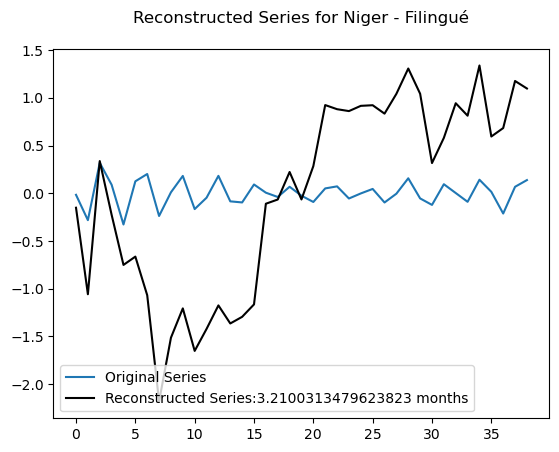

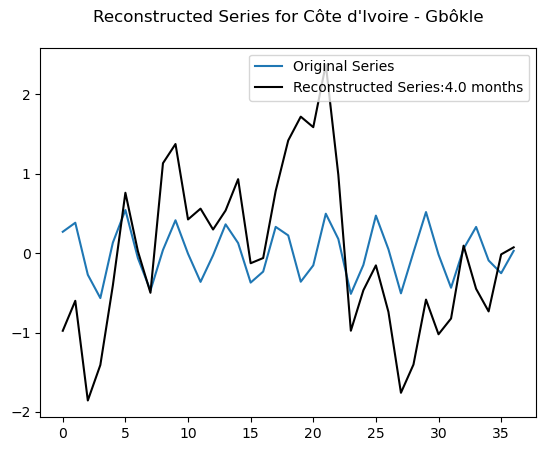

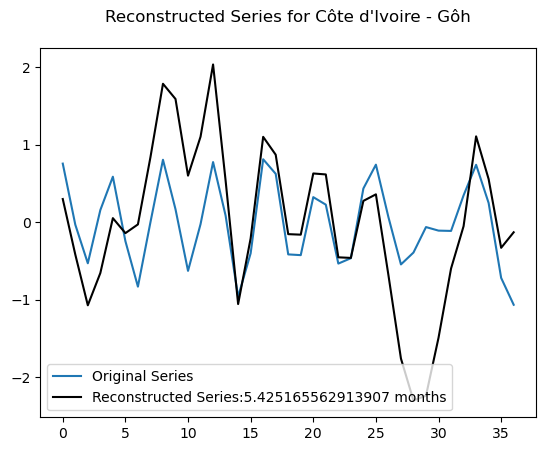

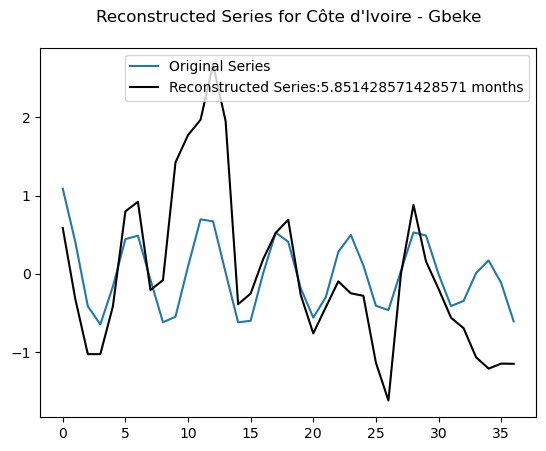

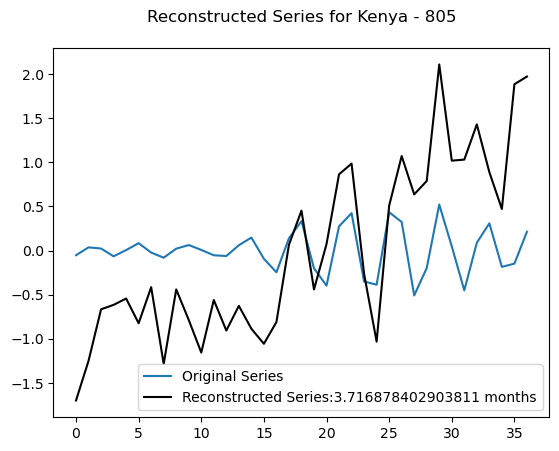

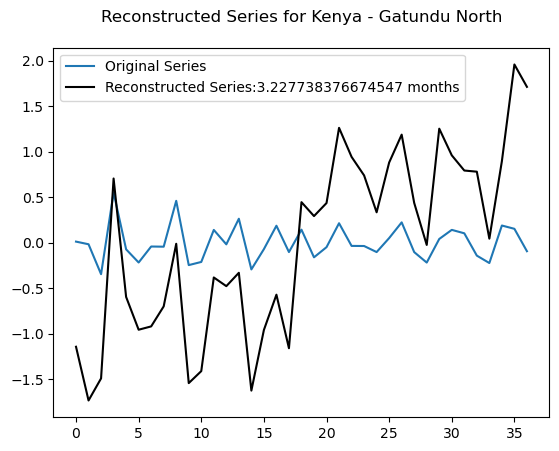

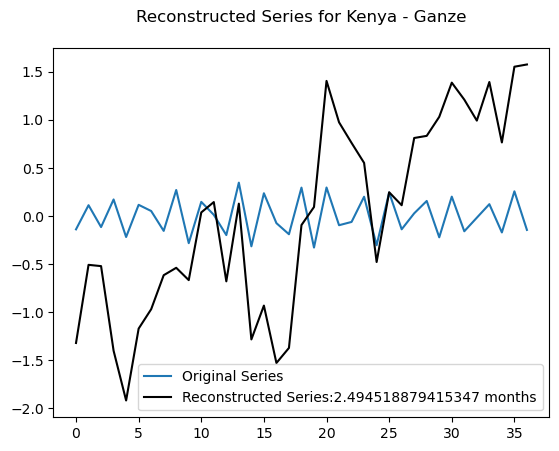

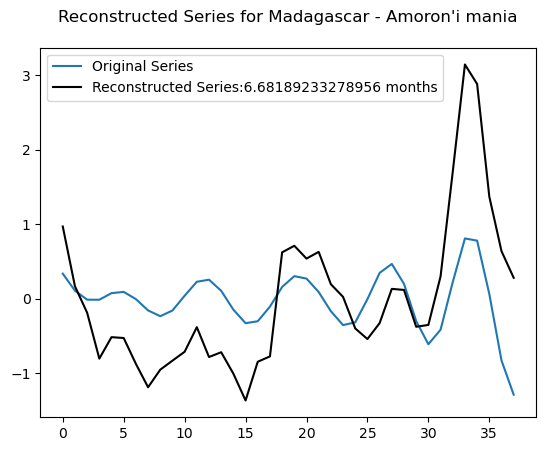

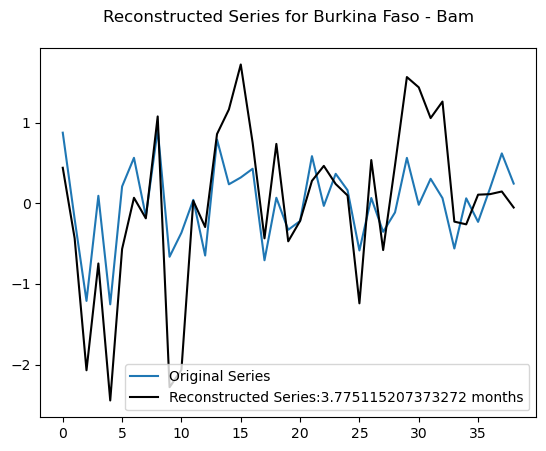

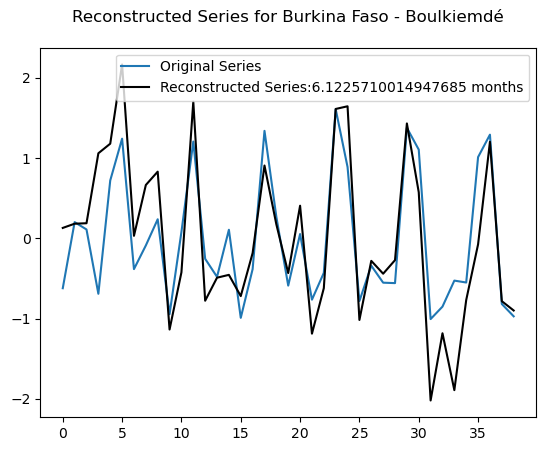

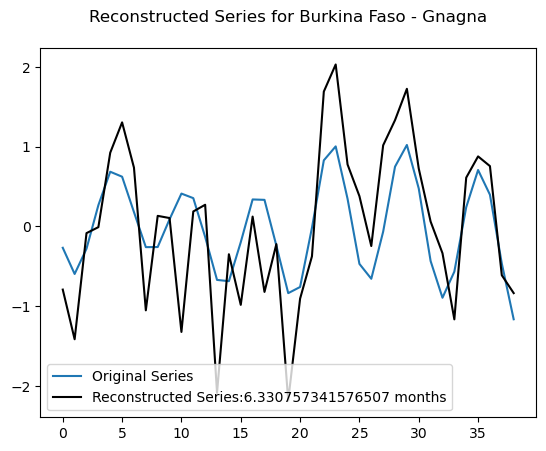

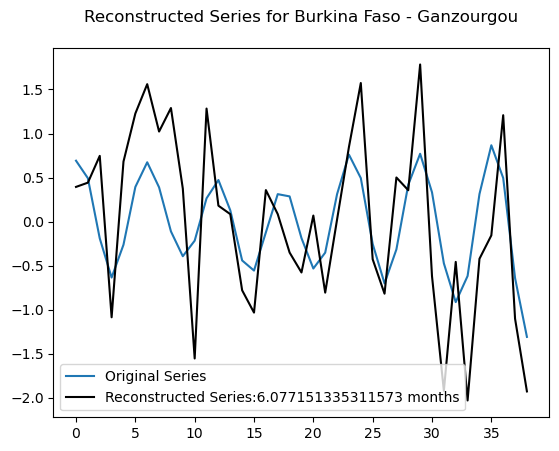

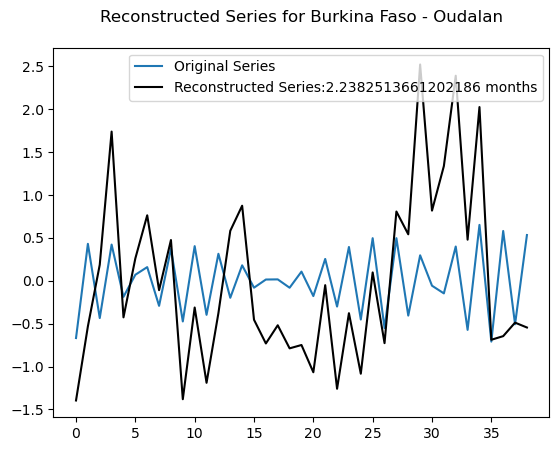

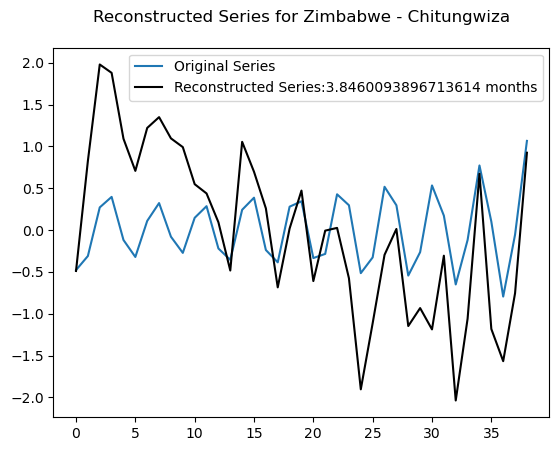

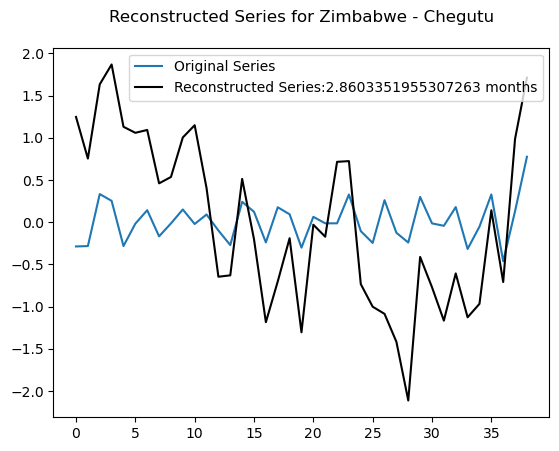

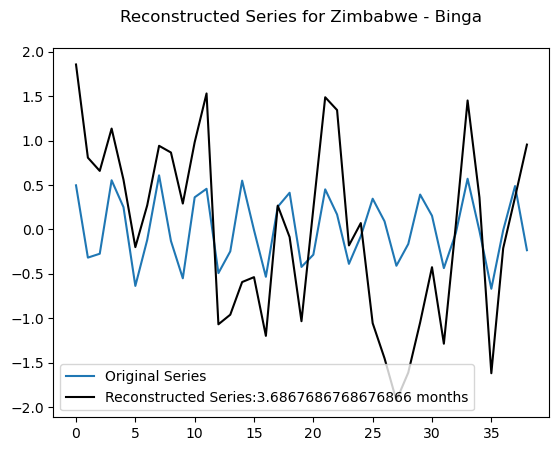

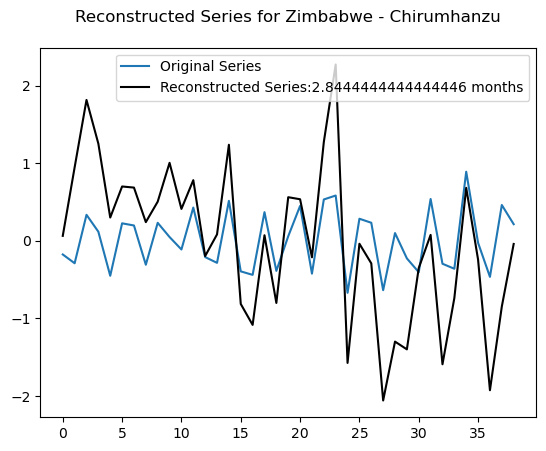

In [42]:
from mcssa import SSA,MCSSA
# Create a working copy to avoid modifying the original DataFrame
df_analysis = fs_data_harmonized[fs_data_harmonized['ADMIN0'].isin(sub_saharan_africa_list)].copy()

# Initialize new columns
df_analysis['non_trend_variance'] = np.nan
df_analysis['sig_period'] = np.nan
df_analysis['sig_variance'] = np.nan

# Create the 'effective_admin_unit' column by using ADMIN2, or ADMIN1 if ADMIN2 is NaN
df_analysis['effective_admin_unit'] = df_analysis['ADMIN2']#.fillna(df_analysis['ADMIN1'])

# Drop rows where 'effective_admin_unit' is still NaN (i.e., both ADMIN1 and ADMIN2 were NaN)
df_analysis.dropna(subset=['effective_admin_unit'], inplace=True)

# Ensure 'year_month' is in datetime format for proper sorting
if not pd.api.types.is_datetime64_any_dtype(df_analysis['year_month']):
    df_analysis['year_month'] = pd.to_datetime(df_analysis['year_month'])

# Iterate through each country
count = 0
#variable = 'ipc_phase_fews'
variable = 'fcs_rt mean' # Change this to the desired variable
for country_name in df_analysis['ADMIN0'].unique():
    country_data = df_analysis[df_analysis['ADMIN0'] == country_name]
    if variable != 'ipc_phase_fews':
        country_data = country_data.drop_duplicates(subset=[variable])
    # Iterate through each effective administrative unit (ADMIN2 or ADMIN1) within the country
    for admin_unit_name in country_data['effective_admin_unit'].unique():
        #print(admin_unit_name)
        # Filter data for the specific country and administrative unit
        admin_unit_data = country_data[country_data['effective_admin_unit'] == admin_unit_name]
        
        # Sort by date to ensure the series is in chronological order
        admin_unit_data_sorted = admin_unit_data.sort_values(by='year_month')
        
        # Get the 'fcs_rt mean' series, drop NaN values to make it "unbroken", and convert to NumPy array
        series = admin_unit_data_sorted[variable].dropna().values
        #print(f"Processing {country_name} - {admin_unit_name} with {len(series)} data points")
        if len(series) > 35:
            count += 1
            if np.std(series)!=0:
                series = (series-np.mean(series))/np.std(series)
                mcssa = MCSSA(series)
                mcssa.run_mcssa(M=13, n_suro=200, algo='VG') # M=13 implies 13 components
                sig_scores = np.array(mcssa.scores) > 90 
                mcssa_values_arr = np.array(mcssa.values)/12
                mcssa_freqs_arr = np.array(mcssa.freqs)
                #mcssa.plot()

                # User's print statement for significant frequencies
                # print(f"Processing {country_name} - {admin_unit_name}")
                # print("Significant frequencies:", mcssa_freqs_arr[sig_scores])
                
                # --- Calculate non_trend_variance ---
                calculated_non_trend_variance = np.real(1 - np.sum(mcssa_values_arr[0:2]))
                # --- Initialize sig_period and sig_variance for this admin unit ---
                calculated_sig_period = np.nan
                calculated_sig_variance = np.nan

                # --- User's conditions for sig_period and sig_variance ---
                # Overall condition: at least two components are significant anywhere in the spectrum
                if sig_scores.sum() > 1:
                            print(sig_scores.sum())
                            #highest_vals = np.argsort(mcssa_values_arr)
                            freq_comp0 = mcssa_freqs_arr[sig_scores][0]
                            freq_comp1 = mcssa_freqs_arr[sig_scores][1]
                            # Check if frequencies of these first two significant components are close
                            # Original user code had a typo in this condition. This is the interpreted correction.
                            if np.abs((freq_comp0 - freq_comp1) / freq_comp1) < 1:
                                calculated_sig_period = 1 / np.mean([freq_comp0, freq_comp1])
                                # Original user formula for sig_variance, applied to first two components
                                calculated_sig_variance = np.real(np.sum(mcssa_values_arr[sig_scores][0:2]))
                                fig1, ax1 = plt.subplots()
                                RC=mcssa.reconstruct(np.where(sig_scores)[0:2])
                                RC.plot()
                                ax1.plot(series,color='black')
                                plt.title(f"Reconstructed Series for {country_name} - {admin_unit_name}\n")
                                plt.legend(['Original Series', 'Reconstructed Series:' + str(calculated_sig_period) + ' months'])
                                # User's print statements
                                #print("Calculated sig_period:", calculated_sig_period)
                                #print("Calculated sig_variance:", calculated_sig_variance)
                # If the above conditions (sig_scores.sum() > 1, sig_scores[0] and sig_scores[1], freqs close)
                # are not met, calculated_sig_period and calculated_sig_variance remain np.nan.
            else:
                # If the standard deviation is zero, we cannot calculate meaningful values
                calculated_non_trend_variance = np.nan
                calculated_sig_period = np.nan
                calculated_sig_variance = np.nan
            # --- Assign calculated values to the DataFrame ---
            # These values apply to all rows of the current admin_unit
            df_analysis.loc[
                (df_analysis['ADMIN0'] == country_name) & 
                (df_analysis['effective_admin_unit'] == admin_unit_name), 
                'non_trend_variance'
            ] = calculated_non_trend_variance
            
            df_analysis.loc[
                (df_analysis['ADMIN0'] == country_name) & 
                (df_analysis['effective_admin_unit'] == admin_unit_name), 
                'sig_period'
            ] = calculated_sig_period

            df_analysis.loc[
                (df_analysis['ADMIN0'] == country_name) & 
                (df_analysis['effective_admin_unit'] == admin_unit_name), 
                'sig_variance'
            ] = calculated_sig_variance

In [43]:
# Filter df_analysis for rows where 'non_trend_variance' is not NaN,
# as these are the only ones for which MCSSA was successfully run and might have sig_period/sig_variance.
df_mcssa_results = df_analysis[(df_analysis['year_month']==df_analysis['year_month'].unique()[-18])&(df_analysis['non_trend_variance'].notna())].copy()

# Group by country ('ADMIN0') and then aggregate the required statistics.
# We use .groupby('ADMIN0').agg(...) for this.
# Note: The aggregation for sig_period and sig_variance should only consider non-NaN values.

summary_table = df_mcssa_results.groupby('ADMIN0').agg(
    avg_non_trend_variance=('non_trend_variance', 'mean'),
    count_sig_period=('sig_period', 'count'),  # Counts non-NaN values
    mean_sig_period=('sig_period', 'mean'),    # Mean of non-NaN values
    std_sig_period=('sig_period', 'std'),      # Std of non-NaN values
    avg_sig_variance=('sig_variance', 'mean'),  # Mean of non-NaN values
    count_unique_effective_admin_unit=('effective_admin_unit', 'nunique') # Count unique admin units
).reset_index()

# Rename columns for clarity
summary_table.rename(columns={
    'ADMIN0': 'Country',
    'avg_non_trend_variance': 'Average Non-Trend Variance',
    'count_sig_period': 'Number of Significant Periods',
    'mean_sig_period': 'Mean Significant Period (months)',
    'std_sig_period': 'Std Dev of Significant Periods (months)',
    'avg_sig_variance': 'Average Significant Variance',
    'count_unique_effective_admin_unit': 'Count of Unique Effective Admin Units'
}, inplace=True)

# Calculate the new metric: count_sig_period divided by count of unique effective_admin_unit
# Ensure 'Count of Unique Effective Admin Units' is not zero to avoid division by zero error
summary_table['Sig Periods per Unique Admin Unit'] = summary_table.apply(
    lambda row: row['Number of Significant Periods'] / row['Count of Unique Effective Admin Units']
    if row['Count of Unique Effective Admin Units'] > 0 else 0,
    axis=1
)

# Display the resulting table
print(summary_table)

         Country  Average Non-Trend Variance  Number of Significant Periods  \
0   Burkina Faso                    0.610418                              5   
1  Côte d'Ivoire                    0.339998                              3   
2          Kenya                    0.366836                              3   
3     Madagascar                    0.352668                              1   
4         Malawi                    0.251031                              0   
5          Niger                    0.116246                              1   
6        Somalia                    0.037273                              0   
7       Zimbabwe                    0.441975                              4   

   Mean Significant Period (months)  Std Dev of Significant Periods (months)  \
0                          4.908769                                 1.821903   
1                          5.092198                                 0.969586   
2                          3.146379             

In [98]:
@pd.api.extensions.register_series_accessor("normalize")
class NormalizeAccessor:
    def __init__(self, series):
        self._series = series

    def __call__(self):
        return (self._series - self._series.min()) / (self._series.max() - self._series.min())


C:\Users\danie\AppData\Local\Temp\ipykernel_28808\3262182652.py:2: UserWarning: registration of accessor <class '__main__.NormalizeAccessor'> under name 'normalize' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  class NormalizeAccessor:


## part 2: Analyze Data

In [ ]:
admin_paths = pd.read_csv(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\nowcasting_food_insecurity_data_and_code_rebuttal_2\database\data\first_level_admin_area_codes.csv")
nowcasting_data = pd.read_csv(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\nowcasting_food_insecurity_data_and_code_rebuttal_2\database\data\train_val_test_dataset.csv")

# Filter admin_paths to include only SSA countries
ssa_admin_paths = admin_paths[admin_paths['adm0_name'].isin(sub_saharan_africa_list)]

# Filter nowcasting_data to include only SSA countries based on adm1_code
ssa_nowcasting_data = nowcasting_data[nowcasting_data['adm1_code'].isin(ssa_admin_paths['adm1_code'])]

# Calculate data lengths for SSA countries
ssa_data_lengths = [len(ssa_nowcasting_data[ssa_nowcasting_data.adm1_code == code]) for code in ssa_nowcasting_data["adm1_code"].unique()]

# Create a dictionary with (adm1_name, adm0_name) as keys and data lengths as values
ssa_data_lengths_dict = {
    (adm1, adm0): length
    for (adm1, adm0), length in zip(
        zip(ssa_admin_paths['adm1_name'], ssa_admin_paths['adm0_name']),
        ssa_data_lengths
    )
}

# Display the dictionary
ssa_data_lengths_dict

In [99]:
import numpy as np
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt

def fourier_uneven(time_vector,signal):
    """
    Perform Fourier analysis on unevenly spaced time series data.
    
    Parameters:
    - time_vector: array-like, time points of the observations
    - signal: array-like, observed values at the time points
    
    Returns:
    - frequency: array of frequencies
    - power: array of power spectral density values
    """
    time_vector = time_vector[np.isfinite(signal)]
    signal = signal[np.isfinite(signal)]
    # Ensure time_vector and signal are numpy arrays and time is numeric
    # Convert datetime to days since the first observation
    time_days = (time_vector - time_vector.min()).dt.total_seconds() / (24 * 3600)
    
    # Perform Lomb-Scargle periodogram analysis
    frequency, power = LombScargle(time_days, signal).autopower(nyquist_factor=5, samples_per_peak=10)
    t = time_days.values
    
    # 2. Compare against white noise null hypothesis
    # Calculate False Alarm Probability (FAP) levels
    # FAP = probability that at least one peak is as high as observed *if* the data were pure noise

    # Find the highest peak
    best_frequency = frequency[np.argmax(power)]
    peak_power = np.max(power)
    peak_period = 1. / best_frequency

    #print(f"Highest peak power: {peak_power:.4f} at frequency {best_frequency:.4f} (period: {peak_period:.2f} days)")

    # Calculate FAP of the highest peak
    fap_peak = LombScargle(t, signal).false_alarm_probability(peak_power)
    if fap_peak < 0.05:
        period = peak_period
    else:
        period = np.nan
    return period

In [100]:

# Ensure time_vector and signal are numpy arrays and time is numeric
# Convert datetime to days since the first observation
time_vector = kigoma_data["date"][kigoma_data["date"]>= "2020-01-01"]
time_days = (time_vector - time_vector.min()).dt.total_seconds() / (24 * 3600)
t = time_days.values
y = kigoma_data.set_index('date')["fcs"].rolling(window='30d', min_periods=1).mean().values[kigoma_data["date"]>= "2020-01-01"] # Assuming 'signal' is the corresponding time series numpy array

# 1. Compute Lomb-Scargle Periodogram
# Define frequency grid (optional, LombScargle can determine automatically)
# nyquist_factor determines how high a frequency to search, relative to the average sampling
# samples_per_peak determines the frequency resolution
frequency, power = LombScargle(t, y).autopower(nyquist_factor=5, samples_per_peak=10)

# 2. Compare against white noise null hypothesis
# Calculate False Alarm Probability (FAP) levels
# FAP = probability that at least one peak is as high as observed *if* the data were pure noise
fap_levels = [0.1, 0.05, 0.01] # Significance levels (e.g., 10%, 5%, 1%)
fap_power = LombScargle(t, y).false_alarm_level(fap_levels)

# Find the highest peak
best_frequency = frequency[np.argmax(power)]
peak_power = np.max(power)
peak_period = 1. / best_frequency

print(f"Highest peak power: {peak_power:.4f} at frequency {best_frequency:.4f} (period: {peak_period:.2f} days)")

# Calculate FAP of the highest peak
fap_peak = LombScargle(t, y).false_alarm_probability(peak_power)
print(f"False Alarm Probability (FAP) of the highest peak: {fap_peak:.4e}")
if fap_peak < 0.05:
    print("The highest peak is statistically significant (p < 0.05) compared to white noise.")
else:
    print("The highest peak is not statistically significant (p >= 0.05) compared to white noise.")

# Plot the periodogram
plt.figure(figsize=(12, 6))
plt.plot(frequency, power, label='Lomb-Scargle Periodogram')

# Plot FAP levels
colors = ['lightgray', 'silver', 'darkgray']
for i, level in enumerate(fap_levels):
    plt.axhline(fap_power[i], linestyle='--', color=colors[i], label=f'FAP {level*100:.0f}% ({fap_power[i]:.2f})')

plt.xlabel('Frequency (1/day)')
plt.ylabel('Lomb-Scargle Power')
plt.title('Lomb-Scargle Periodogram')
plt.legend()
plt.grid(True, alpha=0.5)
# Optional: Zoom in on lower frequencies if peaks are there
# plt.xlim(0, 0.1) # Example limit
plt.show()

# Plot vs Period instead of Frequency
plt.figure(figsize=(12, 6))
periods = 1. / frequency
# Sort by period for plotting
sort_idx = np.argsort(periods)
plt.plot(periods[sort_idx], power[sort_idx], label='Lomb-Scargle Periodogram')

# Plot FAP levels
for i, level in enumerate(fap_levels):
    plt.axhline(fap_power[i], linestyle='--', color=colors[i], label=f'FAP {level*100:.0f}% ({fap_power[i]:.2f})')

plt.xlabel('Period (days)')
plt.ylabel('Lomb-Scargle Power')
plt.title('Lomb-Scargle Periodogram (vs Period)')
plt.legend()
plt.grid(True, alpha=0.5)
plt.xscale('log') # Periods often span orders of magnitude
# Optional: Set x-axis limits for periods of interest
# plt.xlim(10, 1000) # Example limit
plt.show()

NameError: name 'kigoma_data' is not defined

In [108]:
nowcasting_data["date"] = pd.to_datetime(nowcasting_data["date"])

In [109]:
#nowcasting_data.date  = pd.to_datetime(nowcasting_data.date)
food_security_characteristics = {}
for nation in ssa_admin_paths["adm0_name"].unique():
    if nation == "Burkina Faso":
        fs_dict_nation = {}
        for district in ssa_admin_paths["adm1_name"][ssa_admin_paths["adm0_name"]==nation].unique()[0:5]:
                #print(district)
                if len(ssa_admin_paths[(ssa_admin_paths["adm0_name"]==nation)&(ssa_admin_paths["adm1_name"] == district)]) > 1:
                    district_code = ssa_admin_paths[(ssa_admin_paths["adm0_name"]==nation)&(ssa_admin_paths["adm1_name"] == district)].adm1_code.iloc[-1]
                else:
                    district_code = ssa_admin_paths[(ssa_admin_paths["adm0_name"]==nation)&(ssa_admin_paths["adm1_name"] == district)].adm1_code.iloc[0]
                try:
                    print(district_code)
                    kigoma_data = nowcasting_data[nowcasting_data['adm1_code'] == district_code]
                    t = kigoma_data["date"][kigoma_data["date"]>= "2000-01-01"]
                    if len(t) > 1:
                        print(len(t))
                        fcs = kigoma_data.set_index('date')["fcs"].rolling(window='30d', min_periods=1).mean().values[kigoma_data["date"]>= "2000-01-01"]
                        #print(fcs[0])
                        rcsi = kigoma_data.set_index('date')["rcsi"].rolling(window='7d', min_periods=1).mean().values[kigoma_data["date"]>= "2000-01-01"]
                        
                        #print(t.iloc[np.argmax(fcs)])
                        fs_dict_nation[district] = {
                                'fcs': {
                                    'period': fourier_uneven(t, fcs),
                                    'mean': np.nanmean(fcs),
                                    'cv': np.nanstd(fcs) / np.nanmean(fcs) if np.nanmean(fcs) != 0 else np.nan  # Handle division by zero
                                },
                                'rcsi': {
                                    'period': fourier_uneven(t, rcsi),
                                    'mean': np.nanmean(rcsi),
                                    'cv': np.nanstd(rcsi) / np.nanmean(rcsi) if np.nanmean(rcsi) != 0 else np.nan  # Handle division by zero
                                }
                            }
                    else:
                        fs_dict_nation[district]={'fcs':{
                             'period':np.nan,'mean':np.nan,'cv':np.nan},
                             'rcsi':{
                                  'period':np.nan,'mean':np.nan,'cv':np.nan}
                        }
                    plt.scatter(t,fcs,s=1)
                except:
                    pass

                #plt.scatter(pd.to_datetime(kigoma_data["date"]),kigoma_data["rcsi"].rolling(window=8, min_periods=1).mean().normalize(),s=1)
                #plt.scatter(t,y,s=1,label=district)
                #plt.scatter(pd.to_datetime(kigoma_data["date"]),kigoma_data["fcs"],s=1) #checking that not spurious oscillation from slutsky-yule
                #plt.xlim(pd.to_datetime("2020-01-01"), pd.to_datetime("2023-10-01")) 
                # Display the filtered data
                #kigoma_data
                #plt.legend()
        food_security_characteristics[nation] = fs_dict_nation

40276
40277
40278
40279
40280


In [ ]:
#
#. Save the resulting dictionary of food security characteristics
#  to a .json file
#
import json

# Define the file path where you want to save the dictionary
file_path = '../Data/nowcasting_food_insecurity_data_and_code_rebuttal_2/fs_timeseries_stats/food_security_characteristics.json'

# Save the dictionary to a JSON file
try:
    with open(file_path, 'w') as f:
        # Use json.dump to write the dictionary to the file
        # indent=4 makes the output file human-readable
        json.dump(food_security_characteristics, f, indent=4)
    print(f"Dictionary successfully saved to {file_path}")
except Exception as e:
    print(f"An error occurred while saving the dictionary: {e}")

# Optional: Load the dictionary back from the file to verify
try:
    with open(file_path, 'r') as f:
                  loaded_dict = json.load(f)
    print("\nDictionary loaded back from file (first few items):")
    print({k: loaded_dict[k] for k in list(loaded_dict)[:2]}) # Print first 2 nations for brevity
except Exception as e:
     print(f"An error occurred while loading the dictionary back: {e}")

Dictionary successfully saved to ../Data/nowcasting_food_insecurity_data_and_code_rebuttal_2/fs_timeseries_stats/food_security_characteristics.json

Dictionary loaded back from file (first few items):
{'Guinea-Bissau': {}, 'Guinea': {}}


C:\Users\danie\AppData\Local\Temp\ipykernel_117792\4002046698.py:13: RuntimeWarning: invalid value encountered in less
  labels[flat_fs < np.nanquantile(flat_fs,0.2)] = 0
C:\Users\danie\AppData\Local\Temp\ipykernel_117792\4002046698.py:14: RuntimeWarning: invalid value encountered in greater
  labels[flat_fs > np.nanquantile(flat_fs,0.8)] = 2


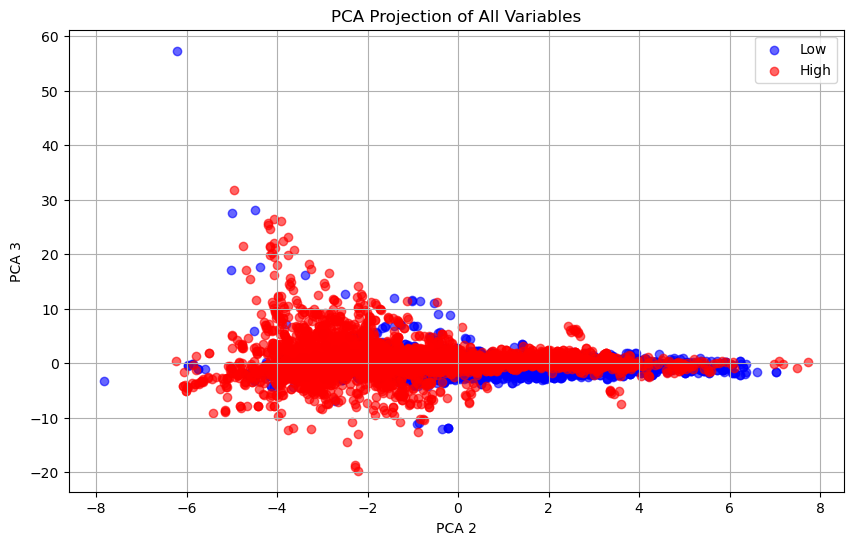

In [ ]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np 

# Reshape as before
reshaped_data = nowcasting_data.values[:,5:38]
flat_fs = nowcasting_data.values[:,2]

# Label encoding: 0 = low, 1 = normal, 2 = high
labels = np.full(flat_fs.shape, 1)
labels[flat_fs < np.nanquantile(flat_fs,0.2)] = 0
labels[flat_fs > np.nanquantile(flat_fs,0.8)] = 2

# Impute & scale
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(reshaped_data)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_imputed)

# PCA projection
pca = PCA(n_components=3)
proj = pca.fit_transform(data_scaled)

# Plot
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red']
names = ['Low', 'Normal', 'High']
for i in [0,2]:
    mask = labels == i
    plt.scatter(proj[mask, 0], proj[mask, 1], alpha=0.6, color=colors[i], label=names[i])
plt.title("PCA Projection of All Variables")
plt.xlabel("PCA 2")
plt.ylabel("PCA 3")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
import plotly.express as px
import plotly.graph_objects as go # Optional: for more customization if needed

# --- Create a Pandas DataFrame for Plotly ---
# Plotly works well with DataFrames
df_pca = pd.DataFrame(proj, columns=['PCA1', 'PCA2', 'PCA3'])
df_pca['Category'] = labels # Add the string labels as a column

# --- Interactive 3D Plotting with Plotly ---

# Define a color map for the categories
color_map = {'Low': 'blue', 'Normal': 'green', 'High': 'red'}

# Create the interactive 3D scatter plot
fig = px.scatter_3d(df_pca,
                    x='PCA1',
                    y='PCA2',
                    z='PCA3',
                    color='Category', # Color points based on the 'Category' column
                    color_discrete_map=color_map, # Apply the defined colors
                    title="Interactive 3D PCA Projection",
                    labels={'PCA1': 'PCA Component 1', # Rename axes for clarity
                            'PCA2': 'PCA Component 2',
                            'PCA3': 'PCA Component 3'},
                    hover_data={'Category': True} # Show category name on hover
                   )
fig.update_traces(marker_size=.5) # You can adjust the value '3' as needed

# Optional: Customize layout further (e.g., figure size)
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=40) # Adjust margins
    # You can add more layout customizations here
)

# Display the plot (this will open in a browser or display in a compatible environment like Jupyter)
fig.show()


NameError: name 'proj' is not defined

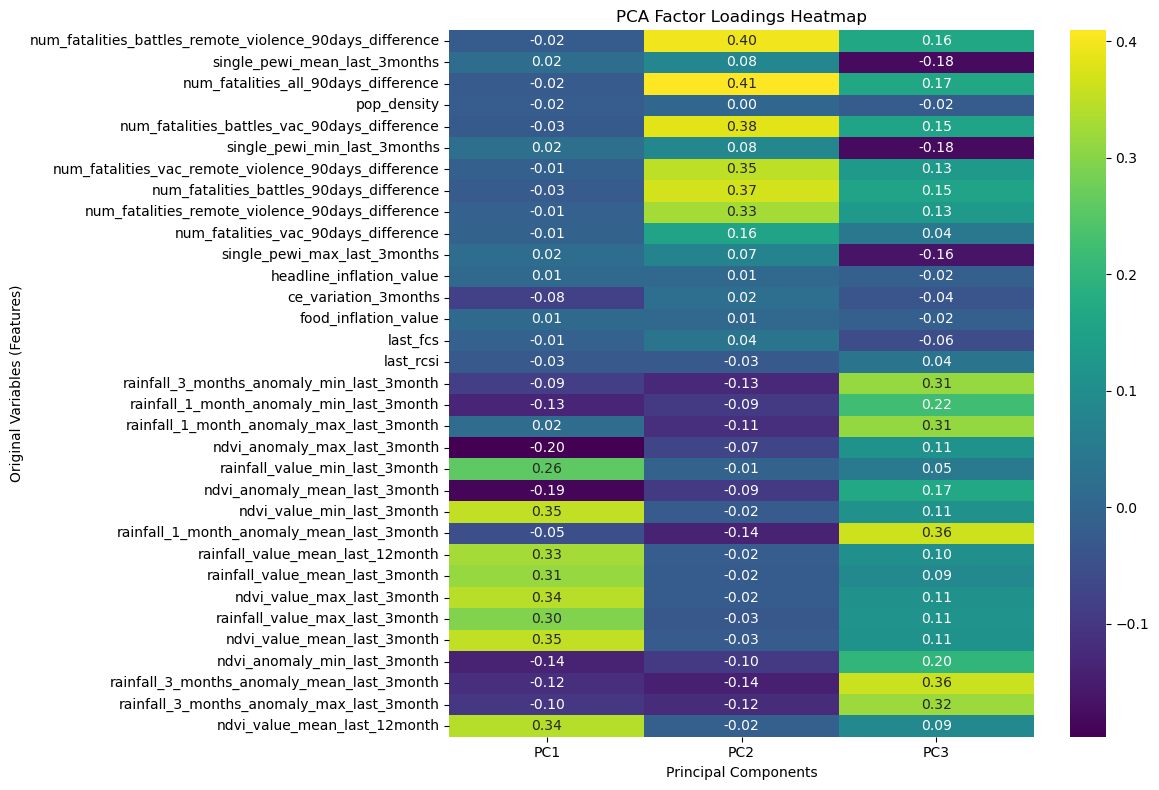

In [ ]:

# The loadings are stored in pca.components_
# Shape: (n_components, n_features)
loadings = pca.components_

# Create feature names for better readability
# These names represent 'OriginalFeature_Timepoint'
feature_names =  nowcasting_data.columns[5:38]
# Make sure the order matches the reshape operation above! Check `data_for_pca` creation.
# If using `reshape(..., -1)`, the order is usually the last index changing fastest.
# If your original shape was (samples, timepoints, features), reshape(samples, -1) order is like:
# F1T1, F1T2, ..., F1Tn, F2T1, F2T2, ..., F2Tn, ...
# Let's adjust the feature name generation assuming (samples, timepoints, features) input
#feature_names = [f'Feat{f}_Time{t}' for f in range(num_features_orig) for t in range(num_timepoints)]
# If your original data was (samples, features, timepoints), the order would be different. Double-check!
# Assuming (samples, timepoints, features) -> reshape(samples, -1) gives:
# T1F1, T1F2, ... T1Fn, T2F1, T2F2, ... T2Fn, ...
# feature_names = [f'Feat{f}_Time{t}' for t in range(num_timepoints) for f in range(num_features_orig)]
# Choose the one that matches your data_timeseries structure and reshape order. Let's stick with the first one.


# Create a DataFrame for easy viewing
# Rows: Principal Components, Columns: Original Variables (Features)
# Transpose loadings so original features are rows and PCs are columns
loadings_df = pd.DataFrame(loadings.T, columns=['PC1', 'PC2','PC3'], index=feature_names)

# You might also want to visualize the loadings, e.g., with a heatmap
import seaborn as sns

plt.figure(figsize=(12, 8)) # Adjust size as needed
sns.heatmap(loadings_df, cmap='viridis', annot=True, fmt='.2f')
plt.title('PCA Factor Loadings Heatmap')
plt.xlabel('Principal Components')
plt.ylabel('Original Variables (Features)')
plt.tight_layout() # Adjust layout
plt.show()